In [1]:
import json
from preprocessor.preprocessor_pytorch import Preprocessor
from model.model_pytorch import Model
from postprocessor.postprocessor import Postprocesser
from evaluator.evaluator_pytorch import Evaluator
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import os
import time
import pickle

class ReversePrediction():
    def set_seed(self, seed_value):
        np.random.seed(seed_value)
        tf.random.set_seed(seed_value)
        random.seed(seed_value)
        torch.manual_seed(seed_value)


    def run(self, params):
        self.set_seed(42)
        preprocessor = Preprocessor(params)
        X_train, y_train, X_val, y_val, X_test, y_test, test_dates, X_newest, x_newest_date, y_newest_date, target_symbol_data, y_train_transition_log, y_val_transition_log, y_test_transition_log = preprocessor.get_multiple_data()
        start_time = time.time()
        model_wrapper = Model(params=params)
        model, history, y_preds, online_training_losses, online_training_acc = \
            model_wrapper.run(X_train, y_train, X_test, y_test, X_val, y_val)
        end_time = time.time()
        execution_time = end_time - start_time
        y_preds = torch.tensor(y_preds, dtype=torch.float32)
        y_preds_original = y_preds.clone()
        y_pred_newest = model.forward(X_newest)
        y_pred_newest = torch.tensor(y_pred_newest, dtype=torch.float32)
        postprocessor = Postprocesser()

        y_test_max_indices = np.argmax(y_test, axis=-1)
        y_preds_max_indices = np.argmax(y_preds, axis=-1)
        y_pred_newest_max_indices = np.argmax(y_pred_newest, axis=-1)
            
        if params["filter_reverse_trend_preds"] == "True":
            y_preds_max_indices = postprocessor.change_values_after_first_reverse_point(y_preds_max_indices)
            
        if params["filter_reverse_trend_preds"] == "True":
            y_pred_newest_max_indices = postprocessor.change_values_after_first_reverse_point(y_pred_newest_max_indices)
            
            test_trade_signals = postprocessor.process_signals(y_test_max_indices, test_dates, False)
        pred_trade_signals = postprocessor.process_signals(y_preds_max_indices, test_dates, params['filter'])
        newest_trade_signals = postprocessor.process_signals(y_pred_newest_max_indices, y_newest_date, False)

        # Get first trend reversal signals
        test_signal = postprocessor.get_first_trend_reversal_signals(y_test_max_indices)
        pred_signal = postprocessor.get_first_trend_reversal_signals(y_preds_max_indices)
        evaluator = Evaluator(params=params)
        model_summary, trend_confusion_matrix_info, reversed_trend_confusion_matrix_info, signal_confusion_matrix_info, \
            roc_auc, pred_days_difference_results, pred_days_difference_abs_mean, pred_in_advance, backtesting_report, trade_summary, execution_time = \
            evaluator.generate_numericale_data(model, y_test, y_preds, test_signal, pred_signal, test_trade_signals, pred_trade_signals, target_symbol_data, execution_time)

        evaluator.get_plots(y_test, y_preds, y_preds_original, test_trade_signals, pred_trade_signals, target_symbol_data, history, online_training_acc, online_training_losses, pred_days_difference_results, pred_days_difference_abs_mean, pred_in_advance, y_test_max_indices, y_preds_max_indices, pred_signal, test_signal, show='False')

        return model_summary, trend_confusion_matrix_info, reversed_trend_confusion_matrix_info, signal_confusion_matrix_info, \
            roc_auc, pred_days_difference_results, pred_days_difference_abs_mean, pred_in_advance, backtesting_report, trade_summary, execution_time


2024-05-16 15:47:27.484077: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 15:47:27.568447: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-16 15:47:27.587100: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-16 15:47:27.938060: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [2]:
with open('parameters.json', 'r') as f:
    params = json.load(f)

In [3]:
params

{'train_indices': ['^GSPC', '^IXIC', '^DJI', '^RUA'],
 'test_indices': '^GSPC',
 'start_date': '2001-01-01',
 'stop_date': '2024-01-01',
 'features_params': [{'type': 'PV', 'oder_days': 20, 'ma_days': 20},
  {'type': 'MACD', 'fastperiod': 5, 'slowperiod': 10, 'signalperiod': 9},
  {'type': 'ROC', 'trend_days': 5},
  {'type': 'Stochastic Oscillator', 'trend_days': 5},
  {'type': 'CCI', 'timeperiod': 14},
  {'type': 'RSI', 'timeperiod': 14},
  {'type': 'MA', 'timeperiod': 20},
  {'type': 'VMA', 'timeperiod': 20},
  {'type': 'pctChange'},
  {'type': '13W Treasury Yield',
   'start_date': '2001-01-01',
   'end_date': '2021-01-01'},
  {'type': '5Y Treasury Yield',
   'start_date': '2001-01-01',
   'end_date': '2021-01-01'},
  {'type': '10Y Treasury Yield',
   'start_date': '2001-01-01',
   'end_date': '2021-01-01'},
  {'type': '30Y Treasury Yield',
   'start_date': '2001-01-01',
   'end_date': '2021-01-01'},
  {'type': 'Bollinger Bands', 'timeperiod': 20, 'nbdevup': 2, 'nbdevdn': 2},
  {'ty

In [7]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema
import talib
from abc import ABC, abstractmethod
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch import from_numpy
import torch
from sklearn.model_selection import train_test_split
import tqdm
import exchange_calendars as xcals
from sklearn.preprocessing import OneHotEncoder


class FeatureBase(ABC):
    """
    Abstract base class for all features.
    """
    @abstractmethod
    def compute(self, data=None, *args, **kwargs):
        """
        Abstract method to compute the feature value for the given data.
        """
        pass


class IndicatorPV(FeatureBase):
    def compute(self, data, *args, **kwargs):
        ma_days = kwargs.get('ma_days', 20)
        oder_days = kwargs.get('oder_days', 20)

        data['MA'] = talib.MA(data['Close'], timeperiod=ma_days)
        local_max_indices = argrelextrema(
            data['MA'].values, np.greater_equal, order=oder_days)[0]
        local_min_indices = argrelextrema(
            data['MA'].values, np.less_equal, order=oder_days)[0]
        # local_max_indices = argrelextrema(
        #     data['Close'].values, np.greater_equal, order=oder_days)[0]
        # local_min_indices = argrelextrema(
        #     data['Close'].values, np.less_equal, order=oder_days)[0]
        data['pv'] = 0
        data['pv'].iloc[local_max_indices] = 1
        data['pv'].iloc[local_min_indices] = 2
        return data

class IndicatorTrend(FeatureBase):
    """
    Indicator to calculate the trend based on various methods.
    """

    def compute(self, data, *args, **kwargs):
        """
        Compute the trend for the given data using the specified method.
        """
        method = kwargs.get('method', 'MA')
        ma_days = kwargs.get('ma_days', 20)
        oder_days = kwargs.get('oder_days', 20)

        if method == 'MA':
            return self.calculate_trend_MA(data, ma_days=ma_days, oder_days=oder_days)
        elif method == 'LocalExtrema':
            return self.calculate_trend_LocalExtrema(data, oder_days=oder_days)
        elif method == 'pv':
            return self.calculate_pv(data, oder_days=oder_days)
        else:
            raise ValueError(f"Invalid trend calculation method: {method}")

    def calculate_trend_MA(self, data, ma_days=20, oder_days=5):
        """
        Calculate trend using Moving Average method.
        TODO: 修改成最高點與最低點決定trend
        """
        # data['MA'] = data['Close'].rolling(window=ma_days).mean()
        data['MA'] = talib.MA(data['Close'], timeperiod=ma_days)
        # data['Trend'] = np.nan
        # n = len(data)

        # for i in range(n - trend_days + 1):
        #     if all(data['MA'].iloc[i + j] < data['MA'].iloc[i + j + 1] for j in range(trend_days - 1)):
        #         data['Trend'].iloc[i:i + trend_days] = 0 # up trend
        #     elif all(data['MA'].iloc[i + j] > data['MA'].iloc[i + j + 1] for j in range(trend_days - 1)):
        #         data['Trend'].iloc[i:i + trend_days] = 1 # down trend
        # data['Trend'].fillna(method='ffill', inplace=True)
        # return data.drop(columns=['MA'])
    
        local_max_indices = argrelextrema(
            data['MA'].values, np.greater_equal, order=oder_days)[0]
        local_min_indices = argrelextrema(
            data['MA'].values, np.less_equal, order=oder_days)[0]
        data['Local Max'] = data.iloc[local_max_indices]['Close']
        data['Local Min'] = data.iloc[local_min_indices]['Close']
        
        data['Trend'] = np.nan
        prev_idx = None
        prev_trend = None
        prev_type = None

        for idx in sorted(np.concatenate([local_max_indices, local_min_indices])):
            if idx in local_max_indices:
                current_type = "max"
            else:
                current_type = "min"
            if prev_trend is None:
                if current_type == "max":
                    prev_trend = 1
                else:
                    prev_trend = 0
            else:
                if prev_type == "max" and current_type == "min":
                    data.loc[prev_idx:idx, 'Trend'] = 1
                    prev_trend = 1 # down trend
                elif prev_type == "min" and current_type == "max":
                    data.loc[prev_idx:idx, 'Trend'] = 0
                    prev_trend = 0 # up trend
                else:
                    if current_type == "max":
                        data.loc[prev_idx:idx, 'Trend'] = 0
                        prev_trend = 0 # up trend
                    else:
                        data.loc[prev_idx:idx, 'Trend'] = 1
                        prev_trend = 1 # down trend
            prev_idx = idx
            prev_type = current_type
        data['Trend'].fillna(method='ffill', inplace=True)
        return data.drop(columns=['MA','Local Max', 'Local Min'])

    def calculate_trend_LocalExtrema(self, data, price_type='Close', oder_days=20):
        """
        Calculate trend using Local Extrema method.
        """
        if price_type == 'Close':
            local_max_indices = argrelextrema(
                data['Close'].values, np.greater_equal, order=oder_days)[0]
            local_min_indices = argrelextrema(
                data['Close'].values, np.less_equal, order=oder_days)[0]
            data['Local Max'] = data.iloc[local_max_indices]['Close']
            data['Local Min'] = data.iloc[local_min_indices]['Close']
        elif price_type == 'HighLow':
            local_max_indices = argrelextrema(
                data['High'].values, np.greater_equal, order=oder_days)[0]
            local_min_indices = argrelextrema(
                data['Low'].values, np.less_equal, order=oder_days)[0]
            data['Local Max'] = data.iloc[local_max_indices]['High']
            data['Local Min'] = data.iloc[local_min_indices]['Low']
        else:
            raise ValueError(f"Invalid price type: {price_type}")
        
        data['Trend'] = np.nan
        prev_idx = None
        prev_trend = None
        prev_type = None

        for idx in sorted(np.concatenate([local_max_indices, local_min_indices])):
            if idx in local_max_indices:
                current_type = "max"
            else:
                current_type = "min"
            if prev_trend is None:
                if current_type == "max":
                    prev_trend = 1
                else:
                    prev_trend = 0
            else:
                if prev_type == "max" and current_type == "min":
                    data.loc[prev_idx:idx, 'Trend'] = 1
                    prev_trend = 1 # down trend
                elif prev_type == "min" and current_type == "max":
                    data.loc[prev_idx:idx, 'Trend'] = 0
                    prev_trend = 0 # up trend
                else:
                    if current_type == "max":
                        data.loc[prev_idx:idx, 'Trend'] = 0
                        prev_trend = 0 # up trend
                    else:
                        data.loc[prev_idx:idx, 'Trend'] = 1
                        prev_trend = 1 # down trend
            prev_idx = idx
            prev_type = current_type
        data['Trend'].fillna(method='ffill', inplace=True)
        return data.drop(columns=['Local Max', 'Local Min'])
    
    def calculate_pv(self, data, oder_days=20):
        # data['MA'] = talib.MA(data['Close'], timeperiod=oder_days)
        # local_max_indices = argrelextrema(
        #     data['MA'].values, np.greater_equal, order=oder_days)[0]
        # local_min_indices = argrelextrema(
        #     data['MA'].values, np.less_equal, order=oder_days)[0]
        local_max_indices = argrelextrema(
            data['Close'].values, np.greater_equal, order=oder_days)[0]
        local_min_indices = argrelextrema(
            data['Close'].values, np.less_equal, order=oder_days)[0]
        data['pv'] = 0
        data['pv'].iloc[local_max_indices] = 1
        data['pv'].iloc[local_min_indices] = 2
        return data

class IndicatorMACD(FeatureBase):
    """
    Indicator to calculate the Moving Average Convergence Divergence (MACD).
    """

    def compute(self, data, *args, **kwargs):
        fastperiod = kwargs.get('fastperiod', 5)
        slowperiod = kwargs.get('slowperiod', 10)
        signalperiod = kwargs.get('signalperiod', 9)
        data['MACD_dif'], data['MACD_dem'], data['MACD_histogram'] = talib.MACD(
            data['Close'], fastperiod=fastperiod, slowperiod=slowperiod, signalperiod=signalperiod)
        return data


class IndicatorROC(FeatureBase):
    def compute(self, data, *args, **kwargs):
        trend_days = kwargs.get('trend_days', 5)
        data['ROC'] = talib.ROC(data['Close'], timeperiod=trend_days)
        return data


class IndicatorStochasticOscillator(FeatureBase):
    def compute(self, data, *args, **kwargs):
        trend_days = kwargs.get('trend_days', 5)
        data['StoK'], data['StoD'] = talib.STOCH(
            data['High'], data['Low'], data['Close'], fastk_period=trend_days, slowk_period=3, slowd_period=3)
        return data


class IndicatorCCI(FeatureBase):
    def compute(self, data, *args, **kwargs):
        timeperiod = kwargs.get('timeperiod', 14)
        data['CCI'] = talib.CCI(data['High'], data['Low'],
                                data['Close'], timeperiod=timeperiod)
        return data


class IndicatorRSI(FeatureBase):
    def compute(self, data, *args, **kwargs):
        timeperiod = kwargs.get('timeperiod', 14)
        data['RSI'] = talib.RSI(data['Close'], timeperiod=timeperiod)
        return data

class IndicatorVMA(FeatureBase):
    def compute(self, data, *args, **kwargs):
        timeperiod = kwargs.get('timeperiod', 20)
        data['VMA'] = talib.MA(data['Volume'], timeperiod=timeperiod)
        return data
    
class IndicatorMA(FeatureBase):
    def compute(self, data, *args, **kwargs):
        timeperiod = kwargs.get('timeperiod', 20)
        data['MA'] = talib.MA(data['Close'], timeperiod=timeperiod)
        return data


class IndicatorPctChange(FeatureBase):
    def compute(self, data, *args, **kwargs):
        data['pctChange'] = data['Close'].pct_change() * 100
        return data


class TreasuryYieldThirteenWeek(FeatureBase):
    def compute(self, data, *args, **kwargs):
        start_date = kwargs.get('start_date')
        end_date = kwargs.get('end_date')
        thirteen_week_treasury_yield = yf.download(
            "^IRX", start_date, end_date)["Close"]
        data['13W Treasury Yield'] = thirteen_week_treasury_yield
        return data


class TreasuryYieldFiveYear(FeatureBase):
    def compute(self, data, *args, **kwargs):
        start_date = kwargs.get('start_date')
        end_date = kwargs.get('end_date')
        five_year_treasury_yield = yf.download(
            "^FVX", start_date, end_date)["Close"]
        data['5Y Treasury Yield'] = five_year_treasury_yield
        return data


class TreasuryYieldTenYear(FeatureBase):
    def compute(self, data, *args, **kwargs):
        start_date = kwargs.get('start_date')
        end_date = kwargs.get('end_date')
        ten_year_treasury_yield = yf.download(
            "^TNX", start_date, end_date)["Close"]
        data['10Y Treasury Yield'] = ten_year_treasury_yield
        return data


class TreasuryYieldThirtyYear(FeatureBase):
    def compute(self, data, *args, **kwargs):
        start_date = kwargs.get('start_date')
        end_date = kwargs.get('end_date')
        thirty_year_treasury_yield = yf.download(
            "^TYX", start_date, end_date)["Close"]
        data['30Y Treasury Yield'] = thirty_year_treasury_yield
        return data
# Add other features here as needed

class IndicatorBollingerBands(FeatureBase):
    def compute(self, data, *args, **kwargs):
        timeperiod = kwargs.get('timeperiod', 20)
        nbdevup = kwargs.get('nbdevup', 2)
        nbdevdn = kwargs.get('nbdevdn', 2)
        data['upperband'], data['middleband'], data['lowerband'] = talib.BBANDS(
            data['Close'], timeperiod=timeperiod, nbdevup=nbdevup, nbdevdn=nbdevdn)
        return data

class IndicatorATR(FeatureBase):
    def compute(self, data, *args, **kwargs):
        timeperiod = kwargs.get('timeperiod', 14)
        data['ATR'] = talib.ATR(data['High'], data['Low'], data['Close'], timeperiod=timeperiod)
        return data

class IndicatorOBV(FeatureBase):
    def compute(self, data, *args, **kwargs):
        data['OBV'] = talib.OBV(data['Close'], data['Volume'])
        return data

# Placeholder for Fibonacci Retracements since it's more of a visual tool and not directly calculable through a simple function.
# You would typically use this by selecting significant price points (peaks and troughs) and then calculating the Fibonacci levels manually or through a graphical interface.
    
class IndicatorParabolicSAR(FeatureBase):
    def compute(self, data, *args, **kwargs):
        start = kwargs.get('start', 0.02)
        increment = kwargs.get('increment', 0.02)
        maximum = kwargs.get('maximum', 0.2)
        data['Parabolic SAR'] = talib.SAR(data['High'], data['Low'], acceleration=start, maximum=maximum)
        return data

class IndicatorMOM(FeatureBase):
    def compute(self, data, *args, **kwargs):
        timeperiod = kwargs.get('timeperiod', 10)
        data['MOM'] = talib.MOM(data['Close'], timeperiod=timeperiod)
        return data

class IndicatorWilliamsR(FeatureBase):
    def compute(self, data, *args, **kwargs):
        lookback_period = kwargs.get('lookback_period', 14)
        data['Williams %R'] = talib.WILLR(data['High'], data['Low'], data['Close'], timeperiod=lookback_period)
        return data

class IndicatorChaikinMF(FeatureBase):
    def compute(self, data, *args, **kwargs):
        timeperiod = kwargs.get('timeperiod', 20)
        data['Chaikin MF'] = talib.ADOSC(data['High'], data['Low'], data['Close'], data['Volume'], fastperiod=3, slowperiod=timeperiod)
        return data
    
    
class FeatureFactory:
    """
    Factory class dedicated to creating various technical features.
    """
    @staticmethod
    def get_feature(feature_type):
        """
        Retrieve the desired feature based on the specified type.
        """
        features = {
            # "Trend": IndicatorTrend,
            "PV": IndicatorPV,
            "MACD": IndicatorMACD,
            "ROC": IndicatorROC,
            "Stochastic Oscillator": IndicatorStochasticOscillator,
            "CCI": IndicatorCCI,
            "RSI": IndicatorRSI,
            "MA": IndicatorMA,
            "VMA": IndicatorVMA,
            "pctChange": IndicatorPctChange,
            "13W Treasury Yield": TreasuryYieldThirteenWeek,
            "5Y Treasury Yield": TreasuryYieldFiveYear,
            "10Y Treasury Yield": TreasuryYieldTenYear,
            "30Y Treasury Yield": TreasuryYieldThirtyYear,
            "Bollinger Bands": IndicatorBollingerBands,
            "ATR": IndicatorATR,
            "OBV": IndicatorOBV,
            "Parabolic SAR": IndicatorParabolicSAR,
            "MOM": IndicatorMOM,
            "Williams %R": IndicatorWilliamsR,
            "Chaikin MF": IndicatorChaikinMF,
            # Add other features here as needed
        }
        feature = features.get(feature_type)
        if feature is None:
            raise ValueError(f"Invalid feature type: {feature_type}")
        return feature()


class CleanerBase(ABC):
    """Abstract base class for data processors."""
    @abstractmethod
    def check(self, data):
        """Method to check the data for issues."""
        pass

    @abstractmethod
    def clean(self, data):
        """Method to clean the data from identified issues."""
        pass


class CleanerMissingValue(CleanerBase):
    """Concrete class for checking and handling missing data."""

    def check(self, data):
        """Check for missing data in the dataframe."""
        return data.isnull().sum()

    def clean(self, data, strategy='auto'):
        """Handle missing data based on the chosen strategy."""
        if strategy == 'auto':
            while data.iloc[0].isnull().any():
                data = data.iloc[1:]
            data.fillna(method='ffill', inplace=True)
        elif strategy == 'drop':
            data.dropna(inplace=True)
        elif strategy == 'fillna':
            data.fillna(method='ffill', inplace=True)
        elif strategy == 'none':
            pass
        else:
            raise ValueError("Invalid strategy provided.")
        return data


class ProcessorFactory:
    """Factory class to creat data processors."""
    @staticmethod
    def get_cleaner(clean_type, *args, **kwargs):
        """creat a data processor based on the provided type."""
        if clean_type == "MissingData":
            return CleanerMissingValue(*args, **kwargs)
        else:
            raise ValueError(f"Processor type {clean_type} not recognized.")

    @staticmethod
    def get_standardize_method(data, method='MinMaxScaler'):
        """Standardize the data using the specified method."""
        if method == 'StandardScaler':
            scaler = StandardScaler()
        elif method == 'MinMaxScaler':
            scaler = MinMaxScaler()
        else:
            raise ValueError(f"Invalid scaler method: {method}.")
        return scaler.fit_transform(data)

    @staticmethod
    def standardize_and_split_data(data, train_split_ratio=0.7, val_split_ratio=0.1, target_col="Trend", feature_cols=None):
        """Standardize the data and split it into training and testing sets."""
        if not feature_cols:
            feature_cols = data.columns.to_list()
        # x_data 設為target_col以外的其他欄位
        # x_data = data.drop(columns=[target_col])
        x_data = data[feature_cols]
        # y_data = np.array(pd.get_dummies(data[target_col]))
        y_data = data[target_col]
        train_split_idx = int(len(x_data) * train_split_ratio)
        val_split_idx = int(len(x_data) * (train_split_ratio + val_split_ratio))
        X_train = x_data.iloc[:train_split_idx]
        y_train = y_data.iloc[:train_split_idx]
        X_val = x_data.iloc[train_split_idx:val_split_idx]
        y_val = y_data.iloc[train_split_idx:val_split_idx]
        X_test = x_data.iloc[val_split_idx:]
        y_test = y_data.iloc[val_split_idx:]
        
        return X_train, y_train, X_val, y_val, X_test, y_test

    @staticmethod
    def prepare_multistep_data(x_data, y_data, look_back, predict_steps, slide_steps=1):
        """
        Prepare the data for multi-step prediction 
        and apply standardization within each sliding window.
        """
        x_date = []
        y_date = []
        x_data_multistep = []
        y_data_multistep = []

        for i in range(0, len(x_data) - look_back - predict_steps + 1, slide_steps):
            x_date.append(x_data.index[i:i + look_back])
            y_date.append(
                x_data.index[i + look_back:i + look_back + predict_steps])
            x_window = x_data.iloc[i:i + look_back].values
            y_window = y_data.iloc[i + look_back:i +
                                   look_back + predict_steps].values
            x_window_standardized = ProcessorFactory.get_standardize_method(
                x_window)
            x_data_multistep.append(x_window_standardized)
            y_data_multistep.append(y_window)
        y_data_multistep = np.array(y_data_multistep)
        y_pv = np.zeros((y_data_multistep.shape[0], 1))
        y_data_multistep = np.array(y_data_multistep)
        for idx in range(y_data_multistep.shape[0]):
            y_pv[idx] = next((x for x in y_data_multistep[idx] if x != 0), 0)
            
        categories = [[0, 1, 2]]
        encoder = OneHotEncoder(categories=categories, sparse=False)
        y_pv = encoder.fit_transform(y_pv)
        return np.array(x_data_multistep), np.array(y_pv), \
            np.array(x_date), np.array(y_date)

    @staticmethod
    def preprocess_for_prediction(x_data, look_back, slide_steps=1):
        """
        Prepare multiple instances of x_data for multi-step prediction.
        """
        x_date = []
        x_data_multistep = []

        for i in range(0, len(x_data) - look_back + 1, slide_steps):
            x_date.append(x_data.index[i:i + look_back])
            x_window = x_data.iloc[i:i + look_back].values
            x_window_standardized = ProcessorFactory.get_standardize_method(
                x_window)
            x_data_multistep.append(x_window_standardized)
        return np.array(x_data_multistep), np.array(x_date)


def generate_stock_price_data(dates, base_price=1000, amplitude=500, slope=0.5, frequency_multiplier=50):
    """
    生成模拟股票价格数据。

    :param dates: 日期序列，pd.DatetimeIndex对象。
    :param base_price: 基础价格，默认为1000。
    :param amplitude: 正弦波的振幅，默认为50。
    :param slope: 每天的价格变化斜率，默认为0.1。
    :param frequency_multiplier: 频率乘数，用于调整频率，默认为200。
    :return: 包含Open, High, Low, Close, Adj Close, Volume字段的DataFrame。
    """
    days = len(dates)  # 数据集包含的天数
    
    # 生成时间序列（0到days-1）
    time_series = np.arange(days)

    # 生成Close价格，加上斜率，调整频率
    close_prices = base_price + amplitude * np.sin(np.linspace(0, 2 * np.pi * frequency_multiplier, days)) + \
        amplitude * np.sin(np.linspace(0, 2 * np.pi * frequency_multiplier*0.5, days)) + \
            slope * time_series + np.random.normal(0, 1000, len(time_series))

    # 生成Open价格（除了第一天外，都是前一天的Close）
    open_prices = np.roll(close_prices, 1)
    open_prices[0] = close_prices[0]  # 第一天的Open设置为第一天的Close

    # 生成High和Low价格
    high_prices = np.maximum(open_prices, close_prices) + 1
    low_prices = np.minimum(open_prices, close_prices) - 1

    # 创建DataFrame
    dataset = pd.DataFrame({
        "Date": dates,
        "Open": open_prices,
        "High": high_prices,
        "Low": low_prices,
        "Adj Close": close_prices,
        "Volume": 1000,  # 假设每天的交易量为1000
        "Close": close_prices
    })

    # 设置日期为索引并返回
    dataset.set_index("Date", inplace=True)
    
    return dataset

class Preprocessor:
    """
    Fetching, processing, and preparing model data.
    """

    def __init__(self, params, start_date=None, end_date=None):
        self.params = params
        self.start_date = start_date
        self.end_date = end_date
        self.features = []
        self.processors = []

    # def fetch_stock_data(self, stock_symbol, start_date=None, end_date=None):
    #     """Fetch stock data from Yahoo Finance."""
    #     if start_date:
    #         self.start_date = start_date
    #     if end_date:
    #         self.end_date = end_date
    #     stock_symbol = '^GSPC'
    #     self.start_date = '2001-01-01'
    #     self.end_date = '2021-01-01'
    #     orginal_dataset =  yf.download(stock_symbol, start=self.start_date, end=self.end_date)
    #     return generate_stock_price_data(orginal_dataset.index)
    
    def fetch_stock_data(self, stock_symbol, start_date=None, end_date=None):
        """Fetch stock data from Yahoo Finance."""
        if start_date:
            self.start_date = start_date
        if end_date:
            self.end_date = end_date
        return yf.download(stock_symbol, start=self.start_date, end=self.end_date)

    def add_feature(self, data, feature_type, *args, **kwargs):
        feature = FeatureFactory.get_feature(feature_type)
        return feature.compute(data, *args, **kwargs)

    def add_data_cleaner(self, data, clean_type='MissingData', strategy='auto'):
        """Method to check and clean the data using a specific processor."""
        processor = ProcessorFactory.get_cleaner(clean_type)
        issues = processor.check(data)
        data = processor.clean(data, strategy=strategy)
        return data, issues
    
    def process_data(self, data, train_split_ratio=0.7, val_split_ratio=0.1, target_col="Trend",
                      feature_cols=None, look_back=64, predict_steps=16, 
                      train_slide_steps=1, test_slide_steps=16, reshape="False"):
        """
        Use ProcessorFactory to standardize and split the data, 
        and prepare it for multi-step prediction if required.
        """
        X_train, y_train, X_val, y_val, X_test, y_test = ProcessorFactory.standardize_and_split_data(
            data, train_split_ratio, val_split_ratio, target_col, feature_cols)

        if look_back and predict_steps:
            X_train, y_train, train_dates, _ = ProcessorFactory.prepare_multistep_data(
                X_train, y_train, look_back, predict_steps, train_slide_steps)
            X_test, y_test, _, test_dates = ProcessorFactory.prepare_multistep_data(
                X_test, y_test, look_back, predict_steps, test_slide_steps)
            X_val, y_val, _, _ = ProcessorFactory.prepare_multistep_data(
                X_val, y_val, look_back, predict_steps, train_slide_steps)
            X_train = from_numpy(X_train).float()
            y_train = from_numpy(y_train).float()
            X_val = from_numpy(X_val).float()
            y_val = from_numpy(y_val).float()
            X_test = from_numpy(X_test).float()
            y_test = from_numpy(y_test).float()
            return X_train, y_train, X_val, y_val, X_test, y_test, train_dates, test_dates
        else:
            raise ValueError(
                "Invalid look_back or predict_steps provided for data preparation.")
        
    def create_x_newest_data(self, data, look_back=64, feature_cols=None, reshape=False):
        """
        Create the newest X data for prediction using a specified number of the latest records.
        """

        if look_back > len(data):
            raise ValueError(
                "look_back exceeds the total number of available records.")
            
        if not feature_cols:
            feature_cols = data.columns.to_list()
        # x_data 設為target_col以外的其他欄位
        # x_data = data.drop(columns=[target_col])
        x_data = data[feature_cols]
        
        newest_data = x_data.tail(look_back)
        X_newest, x_date = ProcessorFactory.preprocess_for_prediction(
            newest_data, look_back)
        if reshape == "True":
            X_newest = self.reshape_data(X_newest)
        X_newest = from_numpy(X_newest).float()
        nyse = xcals.get_calendar("NYSE")
        y_date = nyse.sessions_window(x_date[0][-1], self.params['predict_steps']+1)[1:]
        return X_newest, x_date, np.array(y_date)
    
    def change_values_after_first_reverse_point(self, y:torch.Tensor):
        y_copy = y.clone().detach()
        modified_y = torch.zeros_like(y_copy)
        for idx, sub_y in enumerate(y_copy):
            array = sub_y.numpy()
            transition_found = False
            for i in range(1, len(array)):
                if not (array[i] == array[i-1]).all():
                    array[i:] = array[i]
                    transition_found = True
                    break
            if not transition_found:
                array = sub_y.numpy()
            
            modified_y[idx] = torch.tensor(array)
        return modified_y
    
    def get_multiple_data(self):
        train_indices = self.params['train_indices']
        test_indice = self.params['test_indices']
        X_train_datasets = []
        y_train_datasets = []
        train_dates_list = []
        processed_datasets = []

        for symbol in train_indices:
            dataset = self.fetch_stock_data(symbol, self.params['start_date'], self.params['stop_date'])
            for single_feature_params in self.params['features_params']:
                feature_type = single_feature_params["type"]
                dataset = self.add_feature(dataset, feature_type, **single_feature_params)
            dataset, issues_detected = self.add_data_cleaner(dataset,
                clean_type=self.params['data_cleaning']['clean_type'], strategy=self.params['data_cleaning']['strategy'])
            sub_X_train, sub_y_train, _, _, _, _, sub_train_dates, _ = \
                self.process_data(dataset, train_split_ratio=self.params['train_split_ratio'], val_split_ratio=self.params['val_split_ratio'],
                                        target_col=self.params['target_col'],
                                        feature_cols=self.params['feature_cols'], look_back=self.params['look_back'],
                                        predict_steps=self.params['predict_steps'],
                                        train_slide_steps=self.params['train_slide_steps'],
                                        test_slide_steps=self.params['test_slide_steps'],
                                        reshape=self.params['model_params'][self.params['model_type']]['reshape'])

            X_train_datasets.append(sub_X_train)
            y_train_datasets.append(sub_y_train)
            train_dates_list.append(sub_train_dates)
            processed_datasets.append(dataset)
            
        test_dataset = self.fetch_stock_data(test_indice, self.params['start_date'], self.params['stop_date'])
        for single_feature_params in self.params['features_params']:
            feature_type = single_feature_params["type"]
            test_dataset = self.add_feature(test_dataset, feature_type, **single_feature_params)
        test_dataset, issues_detected = self.add_data_cleaner(test_dataset,
            clean_type=self.params['data_cleaning']['clean_type'], strategy=self.params['data_cleaning']['strategy'])
        _, _, X_val, y_val, X_test, y_test, _, test_dates = \
            self.process_data(test_dataset, train_split_ratio=self.params['train_split_ratio'], val_split_ratio=self.params['val_split_ratio'], 
                                    target_col=self.params['target_col'],
                                    feature_cols=self.params['feature_cols'], look_back=self.params['look_back'],
                                    predict_steps=self.params['predict_steps'],
                                    train_slide_steps=self.params['train_slide_steps'],
                                    test_slide_steps=self.params['test_slide_steps'],
                                    reshape=self.params['model_params'][self.params['model_type']]['reshape'])
        X_newest, x_newest_date, y_date = self.create_x_newest_data(
            test_dataset, 
            look_back=self.params['look_back'], 
            feature_cols=self.params['feature_cols'], 
            reshape=self.params['model_params'][self.params['model_type']]['reshape'])
        
        num_samples = min(len(X) for X in X_train_datasets)
        X_train_combined, y_train_combined = [], []

        for i in range(num_samples):
            for idx in range(len(X_train_datasets)):
                X_train_combined.append(X_train_datasets[idx][i])
                y_train_combined.append(y_train_datasets[idx][i])

        X_train = torch.stack(X_train_combined, dim=0)
        y_train = torch.stack(y_train_combined, dim=0)
        # X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

        # Shuffle X_train and y_train with the same random index
        train_random_index = torch.randperm(X_train.shape[0])
        X_train = X_train[train_random_index]
        y_train = y_train[train_random_index]
        
        val_random_index = torch.randperm(X_val.shape[0])
        X_val = X_val[val_random_index]
        y_val = y_val[val_random_index]
        # val_split_ratio = 0.2
        # X_val = X_test[:int(val_split_ratio * X_test.shape[0]), :, :]
        # y_val = y_test[:int(val_split_ratio * y_test.shape[0]), :, :]
        
        if self.params['filter_reverse_trend_train_test'] == "True":
            y_train = self.change_values_after_first_reverse_point(y_train)
            y_val = self.change_values_after_first_reverse_point(y_val)
            y_test = self.change_values_after_first_reverse_point(y_test)

        print("Training set shape:", X_train.shape)
        print("Validation set shape:", X_val.shape)
        print("Test set shape:", X_test.shape)
        
        return X_train, y_train, X_val, y_val, X_test, y_test, test_dates, X_newest, x_newest_date, y_date, test_dataset


In [8]:
rp = ReversePrediction() 
rp.set_seed(42)
# model_summary, trend_confusion_matrix_info, reversed_trend_confusion_matrix_info, signal_confusion_matrix_info, \
#             roc_auc, pred_days_difference_results, pred_days_difference_abs_mean, pred_in_advance, backtesting_report, trade_summary, execution_time = rp.run(params)

In [9]:
preprocessor = Preprocessor(params)
dataset = preprocessor.fetch_stock_data(preprocessor.params['train_indices'][1], preprocessor.params['start_date'], preprocessor.params['stop_date'])
for single_feature_params in preprocessor.params['features_params']:
    feature_type = single_feature_params["type"]
    dataset = preprocessor.add_feature(dataset, feature_type, **single_feature_params)
dataset, issues_detected = preprocessor.add_data_cleaner(dataset,
    clean_type=preprocessor.params['data_cleaning']['clean_type'], strategy=preprocessor.params['data_cleaning']['strategy'])
sub_X_train, sub_y_train, _, _, _, _, sub_train_dates, _ = \
    preprocessor.process_data(dataset, train_split_ratio=preprocessor.params['train_split_ratio'], val_split_ratio=preprocessor.params['val_split_ratio'],
                            target_col=preprocessor.params['target_col'],
                            feature_cols=preprocessor.params['feature_cols'], look_back=preprocessor.params['look_back'],
                            predict_steps=preprocessor.params['predict_steps'],
                            train_slide_steps=preprocessor.params['train_slide_steps'],
                            test_slide_steps=preprocessor.params['test_slide_steps'],
                            reshape=preprocessor.params['model_params'][preprocessor.params['model_type']]['reshape'])

[*********************100%***********************]  1 of 1 completed
20 20


/tmp/ipykernel_3451192/38024953.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pv'].iloc[local_max_indices] = 1
/tmp/ipykernel_3451192/38024953.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pv'].iloc[local_min_indices] = 2


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [10]:
# preprocessor = Preprocessor(params)
# X_train, y_train, X_val, y_val, X_test, y_test, test_dates, X_newest, x_newest_date, y_newest_date, target_symbol_data = preprocessor.get_multiple_data()


In [11]:
# dataset = preprocessor.fetch_stock_data(preprocessor.params['train_indices'][0], preprocessor.params['start_date'], preprocessor.params['stop_date'])
# for single_feature_params in preprocessor.params['features_params']:
#     feature_type = single_feature_params["type"]
#     dataset = preprocessor.add_feature(dataset, feature_type, **single_feature_params)
# dataset, issues_detected = preprocessor.add_data_cleaner(dataset,
#     clean_type=preprocessor.params['data_cleaning']['clean_type'], strategy=preprocessor.params['data_cleaning']['strategy'])

In [12]:
# x_data = dataset
# y_data = dataset['pv']
# look_back = preprocessor.params['look_back']
# predict_steps = preprocessor.params['predict_steps']
# slide_steps = preprocessor.params['test_slide_steps']

In [13]:
# x_date = []
# y_date = []
# x_data_multistep = []
# y_data_multistep = []

# for i in range(0, len(x_data) - look_back - predict_steps + 1, slide_steps):
#     x_date.append(x_data.index[i:i + look_back])
#     y_date.append(
#         x_data.index[i + look_back:i + look_back + predict_steps])
#     x_window = x_data.iloc[i:i + look_back].values
#     y_window = y_data.iloc[i + look_back:i +
#                             look_back + predict_steps].values
#     x_window_standardized = ProcessorFactory.get_standardize_method(
#         x_window)
#     x_data_multistep.append(x_window_standardized)
#     y_data_multistep.append(y_window)
# y_data_multistep = np.array(y_data_multistep)
# y_pv = np.zeros((y_data_multistep.shape[0], 1))
# y_data_multistep = np.array(y_data_multistep)
# for idx in range(y_data_multistep.shape[0]):
#     y_pv[idx] = next((x for x in y_data_multistep[idx] if x != 0), 0)
    
# categories = [[0, 1, 2]]
# encoder = OneHotEncoder(categories=categories, sparse=False)
# y_pv = encoder.fit_transform(y_pv)

In [14]:
train_indices = preprocessor.params['train_indices']
test_indice = preprocessor.params['test_indices']
X_train_datasets = []
y_train_datasets = []
train_dates_list = []
processed_datasets = []

for symbol in train_indices:
    dataset = preprocessor.fetch_stock_data(symbol, preprocessor.params['start_date'], preprocessor.params['stop_date'])
    for single_feature_params in preprocessor.params['features_params']:
        feature_type = single_feature_params["type"]
        dataset = preprocessor.add_feature(dataset, feature_type, **single_feature_params)
    dataset, issues_detected = preprocessor.add_data_cleaner(dataset,
        clean_type=preprocessor.params['data_cleaning']['clean_type'], strategy=preprocessor.params['data_cleaning']['strategy'])
    sub_X_train, sub_y_train, _, _, _, _, sub_train_dates, _ = \
        preprocessor.process_data(dataset, train_split_ratio=preprocessor.params['train_split_ratio'], val_split_ratio=preprocessor.params['val_split_ratio'],
                                target_col=preprocessor.params['target_col'],
                                feature_cols=preprocessor.params['feature_cols'], look_back=preprocessor.params['look_back'],
                                predict_steps=preprocessor.params['predict_steps'],
                                train_slide_steps=preprocessor.params['train_slide_steps'],
                                test_slide_steps=preprocessor.params['test_slide_steps'],
                                reshape=preprocessor.params['model_params'][preprocessor.params['model_type']]['reshape'])
    X_train_datasets.append(sub_X_train)
    y_train_datasets.append(sub_y_train)
    train_dates_list.append(sub_train_dates)
    processed_datasets.append(dataset)
    
test_dataset = preprocessor.fetch_stock_data(test_indice, preprocessor.params['start_date'], preprocessor.params['stop_date'])
for single_feature_params in preprocessor.params['features_params']:
    feature_type = single_feature_params["type"]
    test_dataset = preprocessor.add_feature(test_dataset, feature_type, **single_feature_params)
test_dataset, issues_detected = preprocessor.add_data_cleaner(test_dataset,
    clean_type=preprocessor.params['data_cleaning']['clean_type'], strategy=preprocessor.params['data_cleaning']['strategy'])
_, _, X_val, y_val, X_test, y_test, _, test_dates = \
    preprocessor.process_data(test_dataset, train_split_ratio=preprocessor.params['train_split_ratio'], val_split_ratio=preprocessor.params['val_split_ratio'], 
                            target_col=preprocessor.params['target_col'],
                            feature_cols=preprocessor.params['feature_cols'], look_back=preprocessor.params['look_back'],
                            predict_steps=preprocessor.params['predict_steps'],
                            train_slide_steps=preprocessor.params['train_slide_steps'],
                            test_slide_steps=preprocessor.params['test_slide_steps'],
                            reshape=preprocessor.params['model_params'][preprocessor.params['model_type']]['reshape'])
X_newest, x_newest_date, y_date = preprocessor.create_x_newest_data(
    test_dataset, 
    look_back=preprocessor.params['look_back'], 
    feature_cols=preprocessor.params['feature_cols'], 
    reshape=preprocessor.params['model_params'][preprocessor.params['model_type']]['reshape'])

num_samples = sum(X.shape[0] for X in X_train_datasets)

X_train = torch.cat(X_train_datasets, dim=0)
y_train = torch.cat(y_train_datasets, dim=0)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Shuffle X_train and y_train with the same random index
# random_index = torch.randperm(X_train.shape[0])
# X_train = X_train[random_index]
# y_train = y_train[random_index]
# val_split_ratio = 0.2
# X_val = X_test[:int(val_split_ratio * X_test.shape[0]), :, :]
# y_val = y_test[:int(val_split_ratio * y_test.shape[0]), :, :]

# if preprocessor.params['filter_reverse_trend_train_test'] == "True":
#     y_train = preprocessor.change_values_after_first_reverse_point(y_train)
#     y_val = preprocessor.change_values_after_first_reverse_point(y_val)
#     y_test = preprocessor.change_values_after_first_reverse_point(y_test)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

[*********************100%***********************]  1 of 1 completed
20 20


/tmp/ipykernel_3451192/38024953.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pv'].iloc[local_max_indices] = 1
/tmp/ipykernel_3451192/38024953.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pv'].iloc[local_min_indices] = 2


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
20 20


/tmp/ipykernel_3451192/38024953.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pv'].iloc[local_max_indices] = 1
/tmp/ipykernel_3451192/38024953.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pv'].iloc[local_min_indices] = 2


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
20 20


/tmp/ipykernel_3451192/38024953.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pv'].iloc[local_max_indices] = 1
/tmp/ipykernel_3451192/38024953.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pv'].iloc[local_min_indices] = 2


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
20 20


/tmp/ipykernel_3451192/38024953.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pv'].iloc[local_max_indices] = 1
/tmp/ipykernel_3451192/38024953.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pv'].iloc[local_min_indices] = 2


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
20 20


/tmp/ipykernel_3451192/38024953.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pv'].iloc[local_max_indices] = 1
/tmp/ipykernel_3451192/38024953.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pv'].iloc[local_min_indices] = 2


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Training set shape: torch.Size([13631, 32, 30])
Validation set shape: torch.Size([1106, 32, 30])
Test set shape: torch.Size([70, 32, 30])


In [15]:
def _kbar(open, close, high, low, pos, ax):  # for US stocks
    if close > open:
        color = 'green'   # rise
        height = close - open
        bottom = open
    else:
        color = 'red'     # fall
        height = open - close
        bottom = close
    ax.bar(pos, height=height, bottom=bottom, width=0.6, color=color)
    ax.vlines(pos, high, low, color=color)

In [16]:
def get_first_trend_reversal_signals(max_indices):
    """
    This function calculates the first trend reversal signal for each row of an array.
    The signal indicates the first change from upward to downward (0 to 1) or
    downward to upward (1 to 0) within each row.

    Parameters:
    - max_indices (ndarray): A 2D numpy array with trend indices (1 for upward, 0 for downward).

    Returns:
    - signals (ndarray): A 1D numpy array containing the first trend reversal signals
                        for each row: 1 for downward to upward, -1 for upward to downward, 
                        and 0 if no reversal is found.
    """
    # Initialize an array to store the signals
    signals = np.zeros((max_indices.shape[0], 1), dtype=int)

    # Iterate over each row to determine the first trend reversal
    for idx in range(max_indices.shape[0]):
        for i in range(1, max_indices.shape[1]):
            # downward to upward
            if max_indices[idx][i - 1] == 1 and max_indices[idx][i] == 0:
                signals[idx] = 1
                break
            # upward to downward
            elif max_indices[idx][i - 1] == 0 and max_indices[idx][i] == 1:
                signals[idx] = -1
                break

    return torch.tensor(signals, dtype=torch.float32)

In [17]:
# y_train_max_indices = np.argmax(y_train, axis=-1)
# y_val_max_indices = np.argmax(y_val, axis=-1)
# y_test_max_indices = np.argmax(y_test, axis=-1)

# postprocessor = Postprocesser()
# y_train_max_indices = postprocessor.change_values_after_first_reverse_point(y_train_max_indices)
# y_val_max_indices = postprocessor.change_values_after_first_reverse_point(y_val_max_indices)
# y_test_max_indices = postprocessor.change_values_after_first_reverse_point(y_test_max_indices)
# train_signal = get_first_trend_reversal_signals(y_train_max_indices)
# train_signal = torch.tensor(np.array(pd.get_dummies(train_signal[:, 0])), dtype=torch.float32)
# val_signal = get_first_trend_reversal_signals(y_val_max_indices)
# val_signal = torch.tensor(np.array(pd.get_dummies(val_signal[:, 0])), dtype=torch.float32)
# test_signal = get_first_trend_reversal_signals(y_test_max_indices)
# test_signal = torch.tensor(np.array(pd.get_dummies(test_signal[:, 0])), dtype=torch.float32)

In [18]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from torch.utils.data import DataLoader, TensorDataset


# TODO: 調整變數名稱，將常數以大寫表示
class EarlyStopper:
    def __init__(self, patience=int(3), min_delta=float(0.01)):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, feature, type='loss'):
        """
        Checks if early stopping criteria is met.

        Args:
            validation_loss (float): The validation loss.

        Returns:
            bool: True if early stopping criteria is met, False otherwise.
        """
        if type == 'loss':
            if feature < self.min_validation_loss:
                self.min_validation_loss = feature
                self.counter = 0
            elif feature > (self.min_validation_loss + self.min_delta):
                self.counter += 1
                if self.counter >= self.patience:
                    return True
            return False
        
        elif type == 'accuracy':
            if feature > self.min_validation_loss:
                self.min_validation_loss = feature
                self.counter = 0
            elif feature < (self.min_validation_loss - self.min_delta):
                self.counter += 1
                if self.counter >= self.patience:
                    return True
            return False
    
class ModelBase(object):
    def _train_model(self):
        """
        Trains the model.

        Raises:
            NotImplementedError: Subclasses should implement this method.
        """
        raise NotImplementedError("Subclasses should implement this method.")

    def _infer_model(self):
        """
        Infers the model.

        Raises:
            NotImplementedError: Subclasses should implement this method.
        """
        raise NotImplementedError("Subclasses should implement this method.")

    def _online_training_model(self):
        """
        Performs online training of the model.

        Raises:
            NotImplementedError: Subclasses should implement this method.
        """
        raise NotImplementedError("Subclasses should implement this method.")

class NeuralNetworkModelBase(ModelBase):
    def __init__(self, params):
        """
        Initializes the ModelPyTorch class.

        Args:
            params (dict): A dictionary containing the parameters for the model.
        """
        self.params = params

    # def _train_model(self, model, X_train, y_train, X_val, y_val, apply_weight):
    #     """
    #     Trains the model.
    #     """
    #     if apply_weight == 'True':
    #         train_weights = self.apply_weights(y_train, self.params['weight_before_reversal'], self.params['weight_after_reversal'])
    #         val_weights = self.apply_weights(y_val, self.params['weight_before_reversal'], self.params['weight_after_reversal'])
    #         # TODO: add function to change loss_function
    #         train_loss_function = nn.CrossEntropyLoss(weight=train_weights)
    #         val_loss_function = nn.CrossEntropyLoss(weight=val_weights)
    #     else:  
    #         train_loss_function = nn.CrossEntropyLoss()
    #         val_loss_function = nn.CrossEntropyLoss()
            
    #     # TODO: add function to change optimizer
    #     optimizer = torch.optim.Adam(model.parameters(), lr=self.params['learning_rate'], weight_decay=self.params['weight_decay'])
    #     early_stopper = EarlyStopper(patience=self.params['patience'], min_delta=self.params['min_delta']) 

    #     train_losses = []
    #     train_accuracy = []
    #     val_losses = []
    #     val_accuracy = []

    #     num_epochs = self.params['training_epoch_num']
    #     for epoch in tqdm(range(num_epochs)):
    #         model.train()
    #         optimizer.zero_grad()

    #         # forward pass
    #         outputs = model(X_train)
    #         loss = train_loss_function(outputs, y_train)
    #         # backward pass and update weights
    #         loss.backward()
    #         optimizer.step()

    #         # calculate training accuracy
    #         _, predicted = torch.max(outputs.data, -1)
    #         correct = (predicted == y_train.argmax(dim=-1)).sum().item()
    #         accuracy = correct / (y_train.size(-3)*y_train.size(-2))
    #         train_losses.append(loss.item())
    #         train_accuracy.append(accuracy)

    #         # calculate validation loss
    #         model.eval()
    #         with torch.no_grad():
    #             val_outputs = model(X_val)
    #             val_loss = val_loss_function(val_outputs, y_val)
    #             _, val_predicted = torch.max(val_outputs.data, -1)
    #             val_correct = (val_predicted == y_val.argmax(dim=-1)).sum().item()
    #             accuracy = val_correct / (y_val.size(-3)*y_val.size(-2))
    #             val_losses.append(val_loss.item())
    #             val_accuracy.append(accuracy)

    #         # early stopping based on training loss
    #         if early_stopper.early_stop(val_loss.item(), type='loss'):             
    #             break

    #     history = {
    #         'loss': train_losses,
    #         'binary_accuracy': train_accuracy,
    #         'val_loss': val_losses,
    #         'val_binary_accuracy': val_accuracy
    #     }
    #     return history, model
    
    def _train_model(self, model, X_train, y_train, X_val, y_val, apply_weight):
        """
        Trains the model.
        """
        # Initialize variables for storing validation loss history
        val_loss_history = []
        epoch_counter = 0
        rollback_epoch = None

        if apply_weight == 'True':
            train_weights = self.apply_weights(y_train, self.params['weight_before_reversal'], self.params['weight_after_reversal'])
            val_weights = self.apply_weights(y_val, self.params['weight_before_reversal'], self.params['weight_after_reversal'])
            # TODO: add function to change loss_function
            train_loss_function = nn.CrossEntropyLoss(weight=train_weights)
            val_loss_function = nn.CrossEntropyLoss(weight=val_weights)
        else: 
            train_loss_function = nn.CrossEntropyLoss()
            val_loss_function = nn.CrossEntropyLoss()

        # TODO: add function to change optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=self.params['learning_rate'], weight_decay=self.params['weight_decay'])
        early_stopper = EarlyStopper(patience=self.params['patience'], min_delta=self.params['min_delta']) 

        train_losses = []
        train_accuracy = []
        val_losses = []
        val_accuracy = []
        rollback_epoch = None

        num_epochs = self.params['training_epoch_num']
        for epoch in tqdm(range(num_epochs)):
            model.train()
            optimizer.zero_grad()

            # forward pass
            outputs = model(X_train)
            loss = train_loss_function(outputs, y_train)
            # backward pass and update weights
            loss.backward()
            optimizer.step()

            # calculate training accuracy
            _, predicted = torch.max(outputs.data, -1)
            correct = (predicted == y_train.argmax(dim=-1)).sum().item()
            accuracy = correct / (y_train.size(0))
            train_losses.append(loss.item())
            train_accuracy.append(accuracy)

            # calculate validation loss
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val)
                val_loss = val_loss_function(val_outputs, y_val)
                _, val_predicted = torch.max(val_outputs.data, -1)
                val_correct = (val_predicted == y_val.argmax(dim=-1)).sum().item()
                accuracy = val_correct / (y_val.size(0))
                val_losses.append(val_loss.item())
                val_accuracy.append(accuracy)

            # Early stopping based on validation loss
            if early_stopper.early_stop(val_loss.item(), type='loss'): 
                # Store validation loss and corresponding epoch
                val_loss_history.append((epoch_counter, val_loss.item()))
                rollback_epoch = epoch_counter - self.params['patience']
                print('rollback_epoch:', rollback_epoch)
                break

            # Store validation loss and corresponding epoch
            val_loss_history.append((epoch_counter, val_loss.item()))
            epoch_counter += 1
            
            # Save model checkpoint
            torch.save(model.state_dict(), f"{self.params['save_path']['trained_model_path']}/model_checkpoint_{epoch_counter}.pt")
        if rollback_epoch is not None:
            model.load_state_dict(torch.load(f"{self.params['save_path']['trained_model_path']}/model_checkpoint_{rollback_epoch}.pt"))

        # # Remove unnecessary checkpoints
        # for i in range(epoch_counter + 1, num_epochs + 1):
        #     if os.path.exists(f"model_checkpoint_{i}.pt"):
        #         os.remove(f"model_checkpoint_{i}.pt")

        history = {
            'loss': train_losses,
            'binary_accuracy': train_accuracy,
            'val_loss': val_losses,
            'val_binary_accuracy': val_accuracy,
            'rollback_epoch': rollback_epoch
        }
        return history, model

    # def _train_model(self, model, X_train, y_train, X_val, y_val, apply_weight):
    #     """
    #     Trains the model.
    #     """
    #     # Initialize variables for storing validation loss history
    #     val_loss_history = []
    #     epoch_counter = 0
    #     rollback_epoch = None

    #     if apply_weight == 'True':
    #         train_weights = self.apply_weights(y_train, self.params['weight_before_reversal'], self.params['weight_after_reversal'])
    #         val_weights = self.apply_weights(y_val, self.params['weight_before_reversal'], self.params['weight_after_reversal'])
    #         # TODO: add function to change loss_function
    #         train_loss_function = nn.CrossEntropyLoss(weight=train_weights)
    #         val_loss_function = nn.CrossEntropyLoss(weight=val_weights)
    #     else: 
    #         train_loss_function = nn.CrossEntropyLoss()
    #         val_loss_function = nn.CrossEntropyLoss()

    #     # TODO: add function to change optimizer
    #     optimizer = torch.optim.Adam(model.parameters(), lr=self.params['learning_rate'], weight_decay=self.params['weight_decay'])
    #     early_stopper = EarlyStopper(patience=self.params['patience'], min_delta=self.params['min_delta']) 

    #     train_losses = []
    #     train_accuracy = []
    #     val_losses = []
    #     val_accuracy = []
    #     rollback_epoch = None

    #     num_epochs = self.params['training_epoch_num']
    #     batch_size = self.params['batch_size'] 
    #     train_dataset = TensorDataset(X_train, y_train)
    #     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 

    #     for epoch in tqdm(range(num_epochs)):
    #         model.train()
    #         running_loss = 0.0
    #         correct = 0
    #         total = 0
    #         for inputs, labels in train_loader:
    #             optimizer.zero_grad()

    #             # forward pass
    #             outputs = model(inputs)
    #             loss = train_loss_function(outputs, labels)
    #             # backward pass and update weights
    #             loss.backward()
    #             optimizer.step()

    #             # calculate training accuracy
    #             _, predicted = torch.max(outputs.data, 1)
    #             total += labels.size(0)
    #             correct += (predicted == labels.argmax(dim=-1)).sum().item()

    #             running_loss += loss.item()

    #         epoch_loss = running_loss / len(train_loader)
    #         epoch_accuracy = correct / total
    #         train_losses.append(epoch_loss)
    #         train_accuracy.append(epoch_accuracy)

    #         # calculate validation loss
    #         model.eval()
    #         with torch.no_grad():
    #             val_outputs = model(X_val)
    #             val_loss = val_loss_function(val_outputs, y_val)
    #             _, val_predicted = torch.max(val_outputs.data, 1)
    #             val_correct = (val_predicted == y_val.argmax(dim=-1)).sum().item()
    #             val_accuracy.append(val_correct / y_val.size(0))
    #             val_losses.append(val_loss.item())

    #         # Early stopping based on validation loss
    #         if early_stopper.early_stop(val_loss.item(), type='loss'): 
    #             # Store validation loss and corresponding epoch
    #             val_loss_history.append((epoch_counter, val_loss.item()))
    #             rollback_epoch = epoch_counter - self.params['patience']
    #             print('rollback_epoch:', rollback_epoch)
    #             break

    #         # Store validation loss and corresponding epoch
    #         val_loss_history.append((epoch_counter, val_loss.item()))
    #         epoch_counter += 1
            
    #         # Save model checkpoint
    #         torch.save(model.state_dict(), f"{self.params['save_path']['trained_model_path']}/model_checkpoint_{epoch_counter}.pt")
        
    #     if rollback_epoch is not None:
    #         model.load_state_dict(torch.load(f"{self.params['save_path']['trained_model_path']}/model_checkpoint_{rollback_epoch}.pt"))

    #     # # Remove unnecessary checkpoints
    #     # for i in range(epoch_counter + 1, num_epochs + 1):
    #     #     if os.path.exists(f"model_checkpoint_{i}.pt"):
    #     #         os.remove(f"model_checkpoint_{i}.pt")

    #     history = {
    #         'loss': train_losses,
    #         'binary_accuracy': train_accuracy,
    #         'val_loss': val_losses,
    #         'val_binary_accuracy': val_accuracy,
    #         'rollback_epoch': rollback_epoch
    #     }
    #     return history, model

    def _infer_model(self, model, X_test):
        """
        Infers the model.

        Args:
            model: The PyTorch model.
            X_test: The input test data.

        Returns:
            The predicted values.
        """
        y_pred = model(X_test)
        return y_pred

    def _online_train_model(self, model, X_train, y_train, single_X_test, 
                        single_y_test, apply_weight, data_update_mode='append'):
        # Update the training dataset with the new instance
        if data_update_mode == 'append':
            online_X_train = torch.cat((X_train, single_X_test), dim=0)
            online_y_train = torch.cat((y_train, single_y_test), dim=0)
        elif data_update_mode == 'replace':
            online_X_train = torch.cat((X_train[1:], single_X_test), dim=0)
            online_y_train = torch.cat((y_train[1:], single_y_test), dim=0)
        elif data_update_mode == 'newest':
            online_X_train = single_X_test
            online_y_train = single_y_test
        else:
            raise ValueError(f"Invalid data update mode: {data_update_mode}")

        # Add the instance and its actual result to the training dataset
        X_train = np.append(X_train, single_X_test, axis=0)
        y_train = np.append(y_train, single_y_test, axis=0)
        
        y_train = torch.tensor(y_train, dtype=torch.float32)
        
        if apply_weight == 'True':
            online_train_weights = self.apply_weights(y_train, self.params['weight_before_reversal'], self.params['weight_after_reversal'])
            loss_function = nn.CrossEntropyLoss(weight=online_train_weights)
        else:
            loss_function = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=self.params['online_train_learning_rate'], weight_decay=self.params['online_train_weight_decay'])
        num_epochs = 10
        history = {}
        for epoch in range(num_epochs):
            # Retrain the model on this updated dataset
            model.train()
            optimizer.zero_grad()

            # forward pass
            outputs = model(online_X_train)
            loss = loss_function(outputs, online_y_train)
            _, predicted = torch.max(outputs.data, -1)
            correct = (predicted == online_y_train.argmax(dim=-1)).sum().item()
            accuracy = correct / (online_y_train.size(-1))
            # backward pass and update weights
            loss.backward()
            optimizer.step()
        history = {
            'loss': loss.item() / online_y_train.size(-2),
            'binary_accuracy': accuracy
            }
        return history, model
    
    def apply_weights(self, y_train: torch.tensor, weight_before_reversal=1, weight_after_reversal=2):
        weights = torch.zeros_like(y_train)
        for idx, sub_y_train in enumerate(y_train):
            array = sub_y_train.numpy()
            sub_weights = [weight_before_reversal] * len(array)
            for i in range(1, len(array)):
                if not (array[i] == array[i-1]).all():
                    sub_weights[i:] = [weight_after_reversal] * (len(array) - i)
                    break
            for j in range(len(sub_weights)):
                weights[idx, j] = torch.tensor([sub_weights[j]] * y_train.shape[2])
        return weights
       
import torch
import torch.nn as nn
import numpy as np
from collections import Counter

class DummyClassifierModelBase(ModelBase):
    def __init__(self, params, input_shape):
        super(DummyClassifierModelBase, self).__init__()
        self.params = params
        
    def _train_model(self, model, X_train, y_train, X_val, y_val, apply_weight):
        label_counts = Counter(y_train)
        self.most_common_label = label_counts.most_common(1)[0][0]

        history = {
            'loss': [],
            'binary_accuracy': [],
            'val_loss': [],
            'val_binary_accuracy': []
        }
        return history, model

    def _infer_model(self, model, X_test):
        batch_size = X_test.size(0)
        predictions = torch.randint(0, 2, (batch_size, self.params['predict_steps'], 2), dtype=torch.float32)
        return predictions

    def _online_train_model(self, model, X_train, y_train, single_X_test, 
                        single_y_test, apply_weight, data_update_mode='append'):
        history = {
            'loss': [],
            'binary_accuracy': []
            }
        return history, model
 
class ModelLeNet(nn.Module, NeuralNetworkModelBase):
    def __init__(self, params=dict(), input_shape=tuple()):
        super(ModelLeNet, self).__init__()
        self.params = params

        # Convolution layers
        self.conv1 = nn.Conv1d(input_shape[1],
                               self.params["model_params"]["LeNet"]["conv_1_out_channels"],
                               kernel_size=self.params["model_params"]["LeNet"]["conv_1_kernel"],
                               padding=self.params["model_params"]["LeNet"]["conv_1_padding"])

        # Calculate size after convolutions and pooling
        self._to_linear = None
        self.convs = nn.Sequential(
            self.conv1,
            nn.ReLU(),
            nn.MaxPool1d(self.params["model_params"]["LeNet"]["MaxPool2d_1_kernel_size"]),  # Will reduce each spatial dimension by half
        )
        self._get_conv_output((1, input_shape[1], self.params["look_back"]))

        # Fully connected layer
        self.fc1 = nn.Linear(self._to_linear, self.params["predict_steps"]*2)

    def _get_conv_output(self, shape):
        with torch.no_grad():
            input = torch.rand(*shape)
            output = self.convs(input)
            self._to_linear = int(torch.flatten(output, 1).shape[1])

    def forward(self, x):
        x = self.convs(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = x.view(-1, 2, self.params["predict_steps"])  # Reshape to the desired output shape
        return x

class ModelLeNet_2layers(nn.Module, NeuralNetworkModelBase):
    def __init__(self, params=dict(), input_shape=tuple()):
        super(ModelLeNet_2layers, self).__init__()
        self.params = params

        # Convolution layers
        self.conv1 = nn.Conv1d(input_shape[1],
                               self.params["model_params"]["LeNet_2"]["conv_1_out_channels"],
                               kernel_size=self.params["model_params"]["LeNet_2"]["conv_1_kernel"],
                               padding=self.params["model_params"]["LeNet_2"]["conv_1_padding"])
        self.conv2 = nn.Conv1d(self.params["model_params"]["LeNet_2"]["conv_1_out_channels"],
                               self.params["model_params"]["LeNet_2"]["conv_2_out_channels"],
                               kernel_size=self.params["model_params"]["LeNet_2"]["conv_2_kernel"],
                               padding=self.params["model_params"]["LeNet_2"]["conv_2_padding"])

        # Calculate size after convolutions and pooling
        self._to_linear = None
        self.convs = nn.Sequential(
            self.conv1,
            nn.LayerNorm([self.params["model_params"]["LeNet_2"]["conv_1_out_channels"],
                          self.params["look_back"]]),
            nn.ReLU(),
            nn.MaxPool1d(self.params["model_params"]["LeNet_2"]["MaxPool2d_1_kernel_size"]),
            self.conv2,
            nn.LayerNorm([self.params["model_params"]["LeNet_2"]["conv_2_out_channels"],
                          int(self.params["look_back"]/self.params["model_params"]["LeNet_2"]["MaxPool2d_2_kernel_size"])]),
            nn.ReLU(),
            nn.MaxPool1d(self.params["model_params"]["LeNet_2"]["MaxPool2d_2_kernel_size"])
        )
        self._get_conv_output((1, input_shape[1], self.params["look_back"]))

        # Fully connected layers
        self.fc1 = nn.Linear(self._to_linear, self.params["model_params"]["LeNet_2"]["fc_1_out_features"])
        self.ln1 = nn.LayerNorm(self.params["model_params"]["LeNet_2"]["fc_1_out_features"])
        self.fc2 = nn.Linear(self.params["model_params"]["LeNet_2"]["fc_1_out_features"],
                             self.params["predict_steps"] * 2)

    def _get_conv_output(self, shape):
        with torch.no_grad():
            input = torch.rand(*shape)
            output = self.convs(input)
            self._to_linear = int(torch.flatten(output, 1).shape[1])

    def forward(self, x):
        x = self.convs(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = x.view(-1, 2, self.params["predict_steps"])  # Reshape to the desired output shape
        return x

class ModelRNN(nn.Module, NeuralNetworkModelBase):
    def __init__(self, params=dict(), input_shape=tuple()):
        super(ModelRNN, self).__init__()
        self.params = params
        self.rnn = nn.RNN(input_size=input_shape[-1],
                          hidden_size=self.params["model_params"]["RNN"]["hidden_size"],
                          num_layers=self.params["model_params"]["RNN"]["num_layers"],
                          dropout=self.params["model_params"]["RNN"]["dropout"],
                          batch_first=True)
        self.lc = nn.LayerNorm([self.params["look_back"], self.params["model_params"]["RNN"]["hidden_size"]])
        self.fc = nn.Linear(self.params["model_params"]["RNN"]["hidden_size"], 2)

    def forward(self, x):
        # Forward pass through RNN
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        output, hidden = self.rnn(x, hidden)
        output = self.lc(output)
        # Reshape output to fit the fully connected layer
        output = output.contiguous().view(-1, self.params["model_params"]["RNN"]["hidden_size"])
        output = self.fc(output)
        # Reshape back to sequence format and align with target sequence length
        output = output.view(batch_size, -1, 2)  # [batch_size, sequence_length, output_size]
        output = torch.sigmoid(output)
        output = output[:, -self.params["predict_steps"]:, :]  # Take the last 'predict_steps' outputs
        return output

    def init_hidden(self, batch_size):
        # Initialize the hidden state
        return torch.zeros(self.params["model_params"]["RNN"]["num_layers"], batch_size, self.params["model_params"]["RNN"]["hidden_size"])

class ModelLSTM(nn.Module, NeuralNetworkModelBase):
    def __init__(self, params=dict(), input_shape=tuple()):
        super(ModelLSTM, self).__init__()
        self.params = params
        self.lstm = nn.LSTM(input_size=input_shape[-1],
                            hidden_size=self.params["model_params"]["LSTM"]["hidden_size"],
                            num_layers=self.params["model_params"]["LSTM"]["num_layers"],
                            dropout=self.params["model_params"]["LSTM"]["dropout"],
                            batch_first=True)
        self.fc = nn.Linear(self.params["model_params"]["LSTM"]["hidden_size"], 2)

    def forward(self, x):
        # Forward pass through LSTM
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        output, (hidden, cell) = self.lstm(x, hidden)
        # Reshape output to fit the fully connected layer
        output = output.contiguous().view(-1, self.params["model_params"]["LSTM"]["hidden_size"])
        output = self.fc(output)
        output = torch.sigmoid(output)
        # Reshape back to sequence format and align with target sequence length
        output = output.view(batch_size, -1, 2)  # [batch_size, sequence_length, output_size]
        output = output[:, -self.params["predict_steps"]:, :]  # Take the last 'predict_steps' outputs
        return output

    def init_hidden(self, batch_size):
        # Initialize the hidden state and cell state
        hidden_state = torch.zeros(self.params["model_params"]["LSTM"]["num_layers"], batch_size, self.params["model_params"]["LSTM"]["hidden_size"])
        cell_state = torch.zeros(self.params["model_params"]["LSTM"]["num_layers"], batch_size, self.params["model_params"]["LSTM"]["hidden_size"])
        return (hidden_state, cell_state)

# class ModelDNN_5layers(nn.Module, NeuralNetworkModelBase):
#     def __init__(self, params, input_shape):
#         super(ModelDNN_5layers, self).__init__()
#         self.params = params
#         # Calculate flattened input size
#         input_size = input_shape[1] * input_shape[2]
#         self.predict_steps = self.params['predict_steps']
#         # Fully connected layers
#         self.fc1 = nn.Linear(input_size, self.predict_steps*32)
#         self.fc2 = nn.Linear(self.predict_steps*32, self.predict_steps*16)
#         self.fc3 = nn.Linear(self.predict_steps*16, self.predict_steps*8)
#         self.fc4 = nn.Linear(self.predict_steps*8, self.predict_steps*4)
#         self.fc5 = nn.Linear(self.predict_steps*4, self.predict_steps*2)
#         # Layer normalization layers
#         self.ln1 = nn.LayerNorm(self.predict_steps*32)
#         self.ln2 = nn.LayerNorm(self.predict_steps*16)
#         self.ln3 = nn.LayerNorm(self.predict_steps*8)
#         self.ln4 = nn.LayerNorm(self.predict_steps*4)
#         self.ln5 = nn.LayerNorm(self.predict_steps*2)
#         self.dropout = nn.Dropout(0.5)

#     def forward(self, x):
#         # Flatten the input
#         x = x.view(x.size(0), -1)  # Flatten to [batch_size, input_size]
#         # Fully connected layers with ReLU activations, layer normalization, and dropout
#         x = F.relu(self.ln1(self.fc1(x)))
#         x = self.dropout(x)
#         x = F.relu(self.ln2(self.fc2(x)))
#         x = self.dropout(x)
#         x = F.relu(self.ln3(self.fc3(x)))
#         x = self.dropout(x)
#         x = F.relu(self.ln4(self.fc4(x)))
#         x = self.dropout(x)
#         x = self.ln5(self.fc5(x))  # Last layer with LayerNorm but without ReLU
#         # Apply sigmoid to the final layer
#         x = torch.sigmoid(x)
#         # Reshape the output to match target shape
#         output = x.view(-1, self.predict_steps, 2)  # Reshape to [batch_size, 2, 8]

#         return output


# class ModelDNN_5layers(nn.Module, NeuralNetworkModelBase):
#     def __init__(self, params, input_shape):
#         super(ModelDNN_5layers, self).__init__()
#         self.params = params
#         # Calculate flattened input size
#         input_size = input_shape[1] * input_shape[2]
#         self.predict_steps = self.params['predict_steps']
        
#         # Define the layers
#         self.fc1 = nn.Linear(input_size, self.predict_steps*32)
#         self.fc2 = nn.Linear(self.predict_steps*32, self.predict_steps*16)
#         self.fc3 = nn.Linear(self.predict_steps*16, self.predict_steps*8)
#         self.fc4 = nn.Linear(self.predict_steps*8, self.predict_steps*4)
#         self.fc5 = nn.Linear(self.predict_steps*4, 3)

#         # Layer normalization and dropout
#         self.ln1 = nn.LayerNorm(self.predict_steps*32)
#         self.ln2 = nn.LayerNorm(self.predict_steps*16)
#         self.ln3 = nn.LayerNorm(self.predict_steps*8)
#         self.ln4 = nn.LayerNorm(self.predict_steps*4)
#         self.ln5 = nn.LayerNorm(3)
#         self.dropout = nn.Dropout(self.params['model_params']["DNN_5layers"]['dropout'])

#         # Apply He Initialization to each linear layer
#         self._init_weights()

#     def _init_weights(self):
#         # Use He initialization for each linear layer
#         nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
#         nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
#         nn.init.kaiming_uniform_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
#         nn.init.kaiming_uniform_(self.fc4.weight, mode='fan_in', nonlinearity='relu')
#         nn.init.kaiming_uniform_(self.fc5.weight, mode='fan_in', nonlinearity='relu')

#         # Optional: Initialize biases with zeros or another method
#         nn.init.zeros_(self.fc1.bias)
#         nn.init.zeros_(self.fc2.bias)
#         nn.init.zeros_(self.fc3.bias)
#         nn.init.zeros_(self.fc4.bias)
#         nn.init.zeros_(self.fc5.bias)
        

#     def forward(self, x):
#         # Flatten the input
#         x = x.view(x.size(0), -1)  # Flatten to [batch_size, input_size]
#         # Fully connected layers with ReLU activations, layer normalization, and dropout
#         x = F.relu(self.ln1(self.fc1(x)))
#         x = self.dropout(x)
#         x = F.relu(self.ln2(self.fc2(x)))
#         x = self.dropout(x)
#         x = F.relu(self.ln3(self.fc3(x)))
#         x = self.dropout(x)
#         x = F.relu(self.ln4(self.fc4(x)))
#         x = self.dropout(x)
#         # Final layer with LayerNorm but without ReLU
#         x = self.ln5(self.fc5(x))
#         # Apply sigmoid to the final layer
#         print(x)
#         # x = F.softmax(x, dim=1)
#         # Reshape the output to match target shape
#         output = x.view(-1, 3)  # Reshape to [batch_size, self.predict_steps, 2]

#         return output

import torch.nn.functional as F

class ModelDNN_5layers(nn.Module, NeuralNetworkModelBase):
    def __init__(self, params, input_shape):
        super(ModelDNN_5layers, self).__init__()
        self.params = params
        # Calculate flattened input size
        input_size = input_shape[1] * input_shape[2]
        self.predict_steps = self.params['predict_steps']
        
        # Define the layers
        self.fc1 = nn.Linear(input_size, self.predict_steps*32)
        self.fc2 = nn.Linear(self.predict_steps*32, self.predict_steps*16)
        self.fc3 = nn.Linear(self.predict_steps*16, self.predict_steps*8)
        self.fc4 = nn.Linear(self.predict_steps*8, self.predict_steps*4)
        self.fc5 = nn.Linear(self.predict_steps*4, 3)

        # Layer normalization and dropout
        self.ln1 = nn.LayerNorm(self.predict_steps*32)
        self.ln2 = nn.LayerNorm(self.predict_steps*16)
        self.ln3 = nn.LayerNorm(self.predict_steps*8)
        self.ln4 = nn.LayerNorm(self.predict_steps*4)
        # Remove LayerNorm from the last layer
        self.dropout = nn.Dropout(self.params['model_params']["DNN_5layers"]['dropout'])

        # Apply He Initialization to each linear layer
        self._init_weights()

    def _init_weights(self):
        # Use He initialization for each linear layer
        nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc4.weight, mode='fan_in', nonlinearity='relu')
        nn.init.xavier_uniform_(self.fc5.weight)
        
        # Optional: Initialize biases with zeros or another method
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)
        nn.init.zeros_(self.fc4.bias)
        nn.init.zeros_(self.fc5.bias)
        
    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)  # Flatten to [batch_size, input_size]
        # Fully connected layers with ReLU activations, layer normalization, and dropout
        x = F.relu(self.ln1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.ln2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.ln3(self.fc3(x)))
        x = self.dropout(x)
        x = F.relu(self.ln4(self.fc4(x)))
        x = self.dropout(x)
        # Final layer without LayerNorm but with ReLU
        x = self.fc5(x)
        # No sigmoid activation here, let CrossEntropyLoss handle it
        output = x  # Output shape: [batch_size, num_classes]

        return output
    
class ModelDNN_3layers(nn.Module, NeuralNetworkModelBase):
    def __init__(self, params, input_shape):
        super(ModelDNN_3layers, self).__init__()
        self.params = params
        # Calculate flattened input size
        input_size = input_shape[1] * input_shape[2]
        self.predict_steps = self.params['predict_steps']
        
        # Define the layers
        self.fc1 = nn.Linear(input_size, self.predict_steps*64)
        self.fc2 = nn.Linear(self.predict_steps*64, self.predict_steps*16)
        self.fc3 = nn.Linear(self.predict_steps*16, 3)

        # Layer normalization and dropout
        self.ln1 = nn.LayerNorm(self.predict_steps*64)
        self.ln2 = nn.LayerNorm(self.predict_steps*16)
        
        # Remove LayerNorm from the last layer
        self.dropout = nn.Dropout(self.params['model_params']["DNN_5layers"]['dropout'])

        # Apply He Initialization to each linear layer
        self._init_weights()

    def _init_weights(self):
        # Use He initialization for each linear layer
        nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.xavier_uniform_(self.fc3.weight)
        # Optional: Initialize biases with zeros or another method
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)
        
    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)  # Flatten to [batch_size, input_size]
        # Fully connected layers with ReLU activations, layer normalization, and dropout
        x = F.relu(self.ln1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.ln2(self.fc2(x)))
        x = self.dropout(x)
        # Final layer without LayerNorm but with ReLU
        x = self.fc3(x)
        # No sigmoid activation here, let CrossEntropyLoss handle it
        output = x  # Output shape: [batch_size, num_classes]

        return output


class DummyClassifier(nn.Module, DummyClassifierModelBase):
    def __init__(self, params, input_shape):
        super(DummyClassifier, self).__init__()
        self.params = params
        self.predict_steps = self.params['predict_steps']

    def forward(self, x):
        # 獲取批次大小
        batch_size = x.size(0)
        # 隨機生成輸出，這裡假設輸出類別數為2，調整為需要的任何數量
        # 使用 torch.rand 生成介於 [0, 1) 的隨機數據，模擬隨機預測的結果
        random_output = torch.rand(batch_size, self.predict_steps, 2)
        return random_output

class ModelCNN_LSTM(nn.Module, NeuralNetworkModelBase):
    def __init__(self, params, input_shape):
        super(ModelCNN_LSTM, self).__init__()
        self.params = params
        self.feature_num = len(params["feature_cols"])
        
        # Convolution layers
        self.conv1 = nn.Conv1d(in_channels=self.feature_num,
                        out_channels=self.feature_num,
                        kernel_size=self.params["model_params"]["CNN_LSTM"]["conv_1_kernel"],
                        padding=self.params["model_params"]["CNN_LSTM"]["conv_1_padding"],
                        groups=self.feature_num)
        self.conv2 = nn.Conv1d(in_channels=self.feature_num,
                        out_channels=self.feature_num,
                        kernel_size=self.params["model_params"]["CNN_LSTM"]["conv_1_kernel"],
                        padding=self.params["model_params"]["CNN_LSTM"]["conv_1_padding"],
                        groups=self.feature_num)
                
        # Calculate size after convolutions and pooling
        self.convs = nn.Sequential(
            self.conv1,
            nn.LayerNorm([self.feature_num,
                          self.params["look_back"]]),
            nn.ReLU(),
            # nn.MaxPool1d(self.params["model_params"]["CNN_LSTM"]["MaxPool2d_1_kernel_size"]),
            self.conv2,
            nn.LayerNorm([self.feature_num,
                          int(self.params["look_back"])]),
            nn.ReLU(),
            # nn.MaxPool1d(self.params["model_params"]["CNN_LSTM"]["MaxPool2d_2_kernel_size"])
        )

        self.lstm = nn.LSTM(input_size=self.feature_num,
                    hidden_size=self.feature_num,
                    num_layers=self.params["model_params"]["CNN_LSTM"]["num_layers"],
                    dropout=self.params["model_params"]["CNN_LSTM"]["dropout"],
                    batch_first=True)
        
        # Fully connected layers
        self.fc = nn.Linear(self.feature_num, 2)
            
    def init_hidden(self, batch_size, x_size):
        # Initialize the hidden state and cell state
        hidden_state = torch.zeros(1, batch_size, self.feature_num)
        cell_state = torch.zeros(1, batch_size, self.feature_num)
        return (hidden_state, cell_state)
    
    def forward(self, x):
        x = x.view(-1, x.shape[-1], x.shape[-2])
        x = self.convs(x)
        x = x.view(-1, x.shape[-1], x.shape[-2])
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size, x.size())
        x, (hidden, cell) = self.lstm(x, hidden)
        x = self.fc(x)
        x = torch.sigmoid(x)
        x = x[:, -self.params["predict_steps"]:, :]

        return x
        
class ModelFactory:
    @staticmethod
    def create_model_instance(model_type, params=None, input_shape=None):
        """
        Creates an instance of the specified model type.

        Args:
            model_type (str): The type of the model to create.
            params (dict): A dictionary containing the parameters for the model.
            input_shape (tuple): The shape of the input data.
            keras_model: The Keras model to be converted to PyTorch model.

        Returns:
            An instance of the specified model type.
        """
        models = {
            "LeNet": ModelLeNet,
            "LeNet_2": ModelLeNet_2layers,
            "RNN": ModelRNN,
            "LSTM": ModelLSTM,
            # "DNN_1layer": ModelDNN_1layer,
            # "DNN_3layers": ModelDNN_3layers,
            "DNN_5layers": ModelDNN_5layers,
            "DNN_3layers": ModelDNN_3layers,
            # "DNN_7layers": ModelDNN_7layers,
            "CNN_LSTM": ModelCNN_LSTM,
            # "seq2seq": Modelseq2seq,
            # "cnn": ModelCNN,
            # "fft": ModelFFT,
            # "ma": ModelMA,
            "DummyClassifier": DummyClassifier
            # Add other models here as needed
        }
        model_instance = models.get(model_type)
        if model_instance is None:
            raise ValueError(f"Invalid model type: {model_type}")
        instance = model_instance(params, input_shape)
        return instance

class Model:
    """A class representing a model for training and inference."""
    def __init__(self, params):
        """
        Initializes the ModelPyTorch class.

        Args:
            params (dict): A dictionary containing the parameters for the model.
        """
        self.params = params
        
    def create_model(self, model_type, input_shape=None):
        """Create a model instance.

        Args:
            model_type (str): The type of the model.
            params (dict, optional): The parameters for the model. Defaults to None.
            input_shape (tuple, optional): The shape of the input data. Defaults to None.

        Returns:
            model_instance: The created model instance.
        """
        model_instance = ModelFactory.create_model_instance(
            model_type, self.params, input_shape)
        return model_instance

    def train_model(self, model, X_train, y_train, X_val, y_val, apply_weight):
        """Train the model.

        Args:
            model: The model instance.
            X_train: The training input data.
            y_train: The training target data.

        Returns:
            The trained model.
        """
        return model._train_model(model, X_train, y_train, X_val, y_val, apply_weight)

    def infer_model(self, model, X_test):
        """Perform inference using the model.

        Args:
            model: The model instance.
            X_test: The input data for inference.

        Returns:
            The predicted output.
        """
        return model._infer_model(model, X_test)

    def online_train_model(self, model, X_train, y_train, single_X_test, 
                        single_y_test, apply_weight, data_update_mode):
        """Perform online training on the model.

        Args:
            model: The model instance.
            X_train: The training input data.
            y_train: The training target data.
            single_X_test: The input data for online training.
            single_y_test: The target data for online training.

        Returns:
            The updated model.
        """
        return model._online_train_model(model, X_train, y_train, single_X_test, 
                        single_y_test, apply_weight, data_update_mode)

    def run(self, X_train, y_train, X_test, y_test, X_val, y_val, pre_trained_model_path=None):
        """Run the model.

        Args:
            model_type (str): The type of the model.
            look_back (int): The number of previous time steps to consider.
            params (dict): The parameters for the model.
            X_train: The training input data.
            y_train: The training target data.
            X_test: The test input data.
            y_test: The test target data.
            pre_trained_model_path (str, optional): The path to a pre-trained model. Defaults to None.

        Returns:
            tuple: A tuple containing the trained model, training history, predicted outputs, 
            online training losses, and online training accuracy.
        """
        if pre_trained_model_path is not None:
            # model = torch.load(pre_trained_model_path)
            input_shape = X_train.shape
            model = self.create_model(self.params['model_type'], input_shape)
            model.load_state_dict(torch.load(pre_trained_model_path))
            history = None
        else:
            input_shape = X_train.shape
            model = self.create_model(self.params['model_type'], input_shape)
            history, model = self.train_model(model, X_train, y_train, X_val, y_val, self.params['apply_weight'])
            # torch.save(model, self.params['trained_model_path'])
            # torch.save(model.state_dict(), os.path.join(save_path_root, self.params['trained_model_path']))
        online_training_losses = []
        online_training_acc = []
        y_preds = []
        
        for i in tqdm(range(len(X_test)), file=open("log.txt", "a")):
            y_pred = self.infer_model(model, X_test[i:i+1])
            y_preds.append(y_pred[0])

            online_history, model = self.online_train_model(
                model, X_train, y_train, X_test[i:i+1], y_test[i:i+1], self.params['apply_weight'], self.params['data_update_mode'])
            online_training_losses.append(online_history['loss'])
            online_training_acc.append(
                online_history['binary_accuracy'])
        # torch.save(model, os.path.join(save_path_root, self.params['online_trained_model_path']))
        y_preds = torch.stack(y_preds).detach().numpy()

        return model, history, y_preds, online_training_losses, online_training_acc


In [19]:
pd.DataFrame(y_train.argmax(dim=-1)).value_counts()

0    9021
1    2327
2    2283
dtype: int64

In [20]:
pd.DataFrame(y_test.argmax(dim=-1)).value_counts()

0    47
1    12
2    11
dtype: int64

In [21]:
pd.DataFrame(y_val.argmax(dim=-1)).value_counts()

0    759
1    176
2    171
dtype: int64

In [22]:
start_time = time.time()
model_wrapper = Model(params=params)
model, history, y_preds, online_training_losses, online_training_acc = \
    model_wrapper.run(X_train, y_train, X_test, y_test, X_val, y_val)
end_time = time.time()
execution_time = end_time - start_time


  4%|▍         | 409/10000 [02:08<50:22,  3.17it/s]  

rollback_epoch: 359


In [23]:
y_preds = torch.tensor(y_preds, dtype=torch.float32)
y_preds_original = y_preds.clone()


In [178]:
int(X_test.shape[1]/2)

15

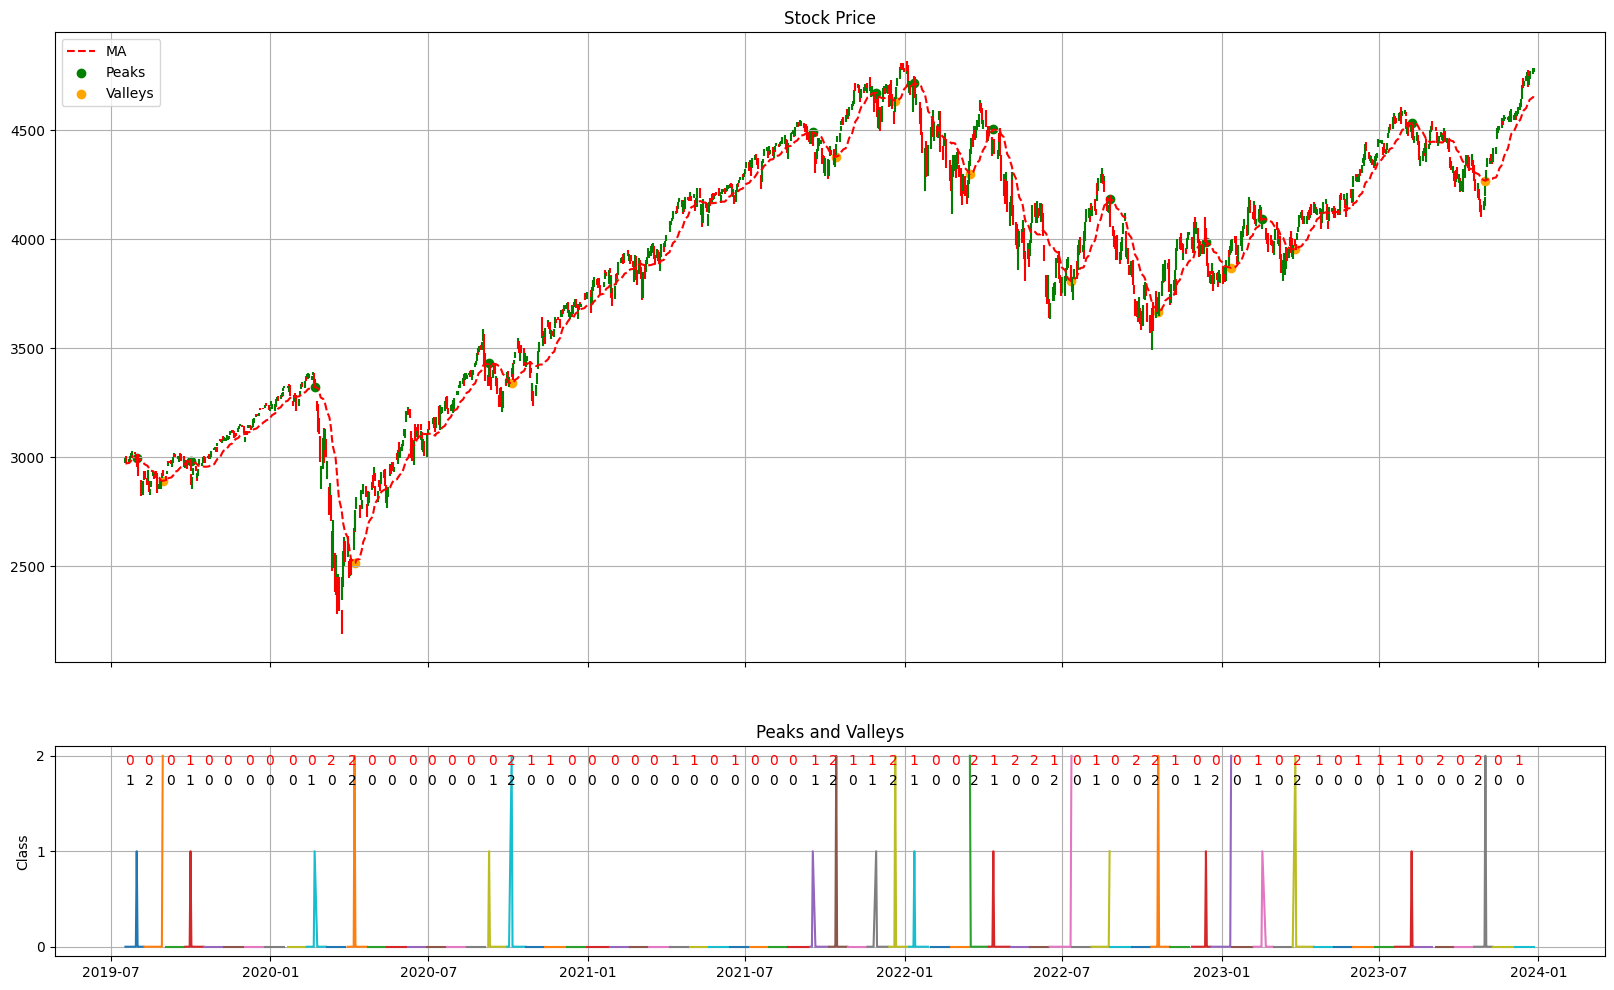

In [211]:
import matplotlib.pyplot as plt

def plot_stock_and_predictions(y_test, y_preds, test_dataset, test_dates, show=True, save_path=None):
    fig, ax = plt.subplots(2, 1, figsize=(20, 12), sharex=True, height_ratios=[3, 1])

    for idx in test_dataset.loc[test_dates[0][0]: test_dates[-1][-1]].index:
        _kbar(test_dataset.loc[idx]['Open'], test_dataset.loc[idx]['Close'], test_dataset.loc[idx]['High'], test_dataset.loc[idx]['Low'], idx, ax[0])
    ax[0].plot(test_dataset['MA'].loc[test_dates[0][0]: test_dates[-1][-1]], label='MA', color='red', linestyle='--')

    peaks_labeled = False
    valleys_labeled = False

    for idx in test_dataset.loc[test_dates[0][0]: test_dates[-1][-1]].index:
        if test_dataset['pv'].loc[idx] == 1:
            ax[0].scatter(idx, test_dataset.loc[idx]['MA'], color='green', label='Peaks' if peaks_labeled == False else '')
            peaks_labeled = True
        elif test_dataset['pv'].loc[idx] == 2:
            ax[0].scatter(idx, test_dataset.loc[idx]['MA'], color='orange', label='Valleys' if valleys_labeled == False else '')
            valleys_labeled = True
    ax[0].set_title('Stock Price')
    ax[0].grid(True)
    ax[0].legend()

    for idx in range(test_dates.shape[0]):
        ax[1].plot(test_dataset['pv'].loc[test_dates[idx]])
        ax[1].annotate(f"{y_test.argmax(dim=-1)[idx]}", (test_dates[idx][0], 1.7), label='actual')
        ax[1].annotate(f"{y_preds.argmax(dim=-1)[idx]}", (test_dates[idx][0], 1.9), color='red', label='predicted')
    ax[1].set_title('Peaks and Valleys')
    ax[1].set_ylabel('Class')
    ax[1].set_yticks([0, 1, 2])
    ax[1].grid(True)
    if show:
        plt.show()
    else:
        plt.close()
    if save_path is not None:
        plt.savefig(save_path)

plot_stock_and_predictions(y_test, y_preds, test_dataset, test_dates)


In [25]:
np.argmax(y_preds, axis=-1)

tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0,
        0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 2, 1, 1, 2, 1, 0, 0, 2, 1, 2, 2, 1, 0,
        1, 0, 2, 2, 1, 0, 0, 0, 1, 0, 2, 1, 0, 1, 1, 1, 0, 2, 0, 2, 0, 1])

In [26]:
np.argmax(y_test, axis=-1)

tensor([1, 2, 0, 1, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 2, 1, 0, 0, 2, 1, 0, 0, 2, 0,
        1, 0, 0, 2, 0, 1, 2, 0, 1, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0])

In [27]:
history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy', 'rollback_epoch'])

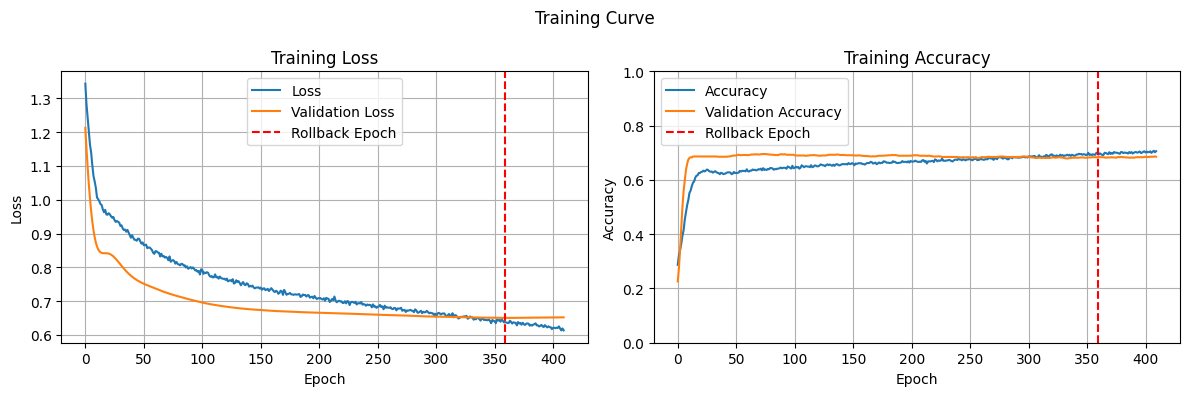

In [28]:
evaluator = Evaluator(params)
evaluator.plot_training_curve(history, show=True)

In [29]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1).flatten(), np.argmax(y_preds, axis=-1).flatten(), labels=[0, 1, 2])

In [30]:
cm

array([[31, 11,  5],
       [ 4,  8,  0],
       [ 2,  1,  8]])

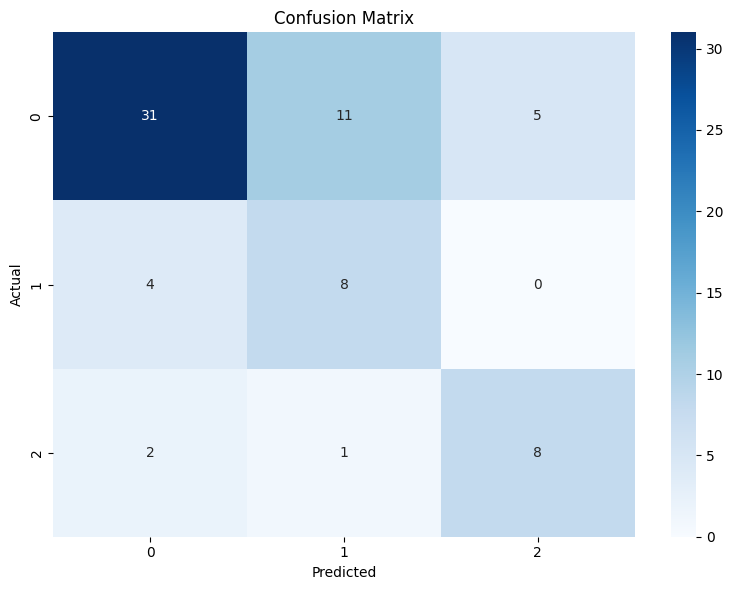

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [32]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

In [87]:
categories = [[0, 1, 2]]
encoder = OneHotEncoder(categories=categories, sparse=False)
y_pv = encoder.fit_transform(y_preds.argmax(dim=-1).reshape(-1, 1))
y_pv = torch.tensor(y_pv, dtype=torch.float32)

In [103]:
import torch
import pandas as pd

def calculate_metrics(y_test, y_preds):
    metrics = []
    
    for i in range(y_test.shape[1]):  # 遍历每个类别
        y_test_class = y_test[:, i]
        y_preds_class = y_preds[:, i]
        # Calculate True Positives, True Negatives, False Positives, False Negatives
        TP = ((y_preds_class == 1) & (y_test_class == 1)).sum().item()
        TN = ((y_preds_class == 0) & (y_test_class == 0)).sum().item()
        FP = ((y_preds_class == 1) & (y_test_class == 0)).sum().item()
        FN = ((y_preds_class == 0) & (y_test_class == 1)).sum().item()
        
        # Calculate Accuracy
        accuracy = (TP + TN) / (TP + TN + FP + FN) if TP + TN + FP + FN != 0 else 0

        # Calculate Precision
        precision = TP / (TP + FP) if TP + FP != 0 else 0

        # Calculate Recall
        recall = TP / (TP + FN) if TP + FN != 0 else 0

        # Calculate F1-Score
        f1_score = (2 * precision * recall) / (precision + recall) if precision + recall != 0 else 0

        # Calculate Specificity
        specificity = TN / (TN + FP) if TN + FP != 0 else 0

        # Calculate False Positive Rate
        fpr = FP / (FP + TN) if FP + TN != 0 else 0

        # Calculate False Negative Rate
        fnr = FN / (FN + TP) if FN + TP != 0 else 0

        metrics.append([accuracy, precision, recall, f1_score, specificity, fpr, fnr])

    # Create DataFrame to store metrics
    confusion_metrics_info = pd.DataFrame(metrics, columns=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificity', 'False Positive Rate', 'False Negative Rate'])
    confusion_metrics_info.index.name = 'Class'
    
    return confusion_metrics_info

# Convert tensors to numpy arrays
y_test_np = y_test.numpy()
y_preds_np = y_preds.numpy()

# Calculate metrics
confusion_metrics_info = calculate_metrics(y_test, y_pv)
print(confusion_metrics_info)


       Accuracy  Precision    Recall  F1-Score  Specificity  \
Class                                                         
0      0.685714   0.837838  0.659574  0.738095     0.739130   
1      0.771429   0.400000  0.666667  0.500000     0.793103   
2      0.885714   0.615385  0.727273  0.666667     0.915254   

       False Positive Rate  False Negative Rate  
Class                                            
0                 0.260870             0.340426  
1                 0.206897             0.333333  
2                 0.084746             0.272727  


In [104]:
confusion_metrics_info

,Accuracy,Precision,Recall,F1-Score,Specificity,False Positive Rate,False Negative Rate
Class,,,,,,,
0,0.685714,0.837838,0.659574,0.738095,0.739130,0.260870,0.340426
1,0.771429,0.400000,0.666667,0.500000,0.793103,0.206897,0.333333
2,0.885714,0.615385,0.727273,0.666667,0.915254,0.084746,0.272727


In [97]:
accuracy = accuracy_score(np.argmax(y_test, axis=-1).flatten(), np.argmax(y_preds, axis=-1).flatten())
precision = precision_score(np.argmax(y_test, axis=-1).flatten(), np.argmax(y_preds, axis=-1).flatten(), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1).flatten(), np.argmax(y_preds, axis=-1).flatten(), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1).flatten(), np.argmax(y_preds, axis=-1).flatten(), average='macro')
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}")

Accuracy: 0.6714285714285714, Precision: 0.6177408177408178, Recall: 0.6845046206748334, F1: 0.634920634920635


In [34]:
y_pred_newest = model.forward(X_newest)
y_pred_newest = torch.tensor(y_pred_newest, dtype=torch.float32)


/tmp/ipykernel_3451192/2604493356.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_newest = torch.tensor(y_pred_newest, dtype=torch.float32)


In [106]:
y_test_max_indices = np.argmax(y_test, axis=-1)
y_preds_max_indices = np.argmax(y_preds, axis=-1)
y_pred_newest_pv = np.argmax(y_pred_newest, axis=-1)


In [378]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import json
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score

class Evaluator:
    def __init__(self, params):
        self.params = params
        pass
    
    def plot_reversals_ratio_multi(self, y_train_max_indices, y_val_max_indices, y_test_max_indices, y_preds_max_indices, show=True, save_path=None):
        fig, axs = plt.subplots(2, 2, figsize=(12, 6))
        data_sets = [y_train_max_indices, y_val_max_indices, y_test_max_indices, y_preds_max_indices]
        set_labels = ['Train', 'Validation', 'Test', 'Predictions']
        
        for idx, y_data in enumerate(data_sets):
            y_data_label = self._change_labels(y_data, abbreviation=False)
            counts = pd.DataFrame(y_data_label).value_counts()
            labels = ['No Reversal', 'Peak', 'Valley']
            
            row_idx = idx // 2
            col_idx = idx % 2
            
            ax_pie = axs[row_idx, col_idx]
            patches, texts, _ = ax_pie.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
            ax_pie.axis('equal')
            ax_pie.set_title(f'Reversals Ratio ({set_labels[idx]})')
            
            labels_text = [f'{label}\n({count})' for label, count in zip(labels, counts)]
            ax_pie.legend(patches, labels_text, loc='upper right')

        plt.tight_layout()
        if show:
            plt.show()
        else:
            plt.close()
        if save_path:
            plt.savefig(save_path)

    def get_confusion_matrix(self, y_test, y_preds, show=True, save_path=None):
        # Convert tensors to numpy arrays
        y_test_np = y_test.numpy()
        y_preds_np = y_preds.numpy()

        # Calculate metrics for each class
        accuracy = accuracy_score(y_test_np, y_preds_np)
        precision = precision_score(y_test_np, y_preds_np, average=None, zero_division=0)
        recall = recall_score(y_test_np, y_preds_np, average=None, zero_division=0)
        f1 = f1_score(y_test_np, y_preds_np, average=None, zero_division=0)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test_np, y_preds_np)

        # Extract True Positives, True Negatives, False Positives, False Negatives
        TN = cm[0, 0]
        FN = cm[1, 1]
        FP = cm[0, 1]
        TP = cm[1, 0]

        # Calculate Specificity
        specificity = TN / (TN + FP) if TN + FP != 0 else 0

        # Calculate False Positive Rate
        fpr = FP / (FP + TN) if FP + TN != 0 else 0

        # Calculate False Negative Rate
        fnr = FN / (FN + TP) if FN + TP != 0 else 0

        # Calculate micro-averaging metrics
        micro_precision = precision_score(y_test_np, y_preds_np, average='micro', zero_division=0)
        micro_recall = recall_score(y_test_np, y_preds_np, average='micro', zero_division=0)
        micro_f1 = f1_score(y_test_np, y_preds_np, average='micro', zero_division=0)

        # Calculate macro-averaging metrics
        macro_precision = precision_score(y_test_np, y_preds_np, average='macro', zero_division=0)
        macro_recall = recall_score(y_test_np, y_preds_np, average='macro', zero_division=0)
        macro_f1 = f1_score(y_test_np, y_preds_np, average='macro', zero_division=0)

        # Create DataFrame to store metrics
        confusion_metrics_info = pd.DataFrame({
            'Class': range(len(precision)),
            'Accuracy': [accuracy]*len(precision),
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Specificity': [specificity]*len(precision),
            'False Positive Rate': [fpr]*len(precision),
            'False Negative Rate': [fnr]*len(precision)
        })
        
        # Add macro-averaging metrics
        macro_avg_info = pd.DataFrame({
            'Class': ['Macro-average'],
            'Accuracy': [accuracy],
            'Precision': [macro_precision],
            'Recall': [macro_recall],
            'F1-Score': [macro_f1],
            'Specificity': [specificity],
            'False Positive Rate': [fpr],
            'False Negative Rate': [fnr]
        })
        
        # Add micro-averaging metrics
        micro_avg_info = pd.DataFrame({
            'Class': ['Micro-average'],
            'Accuracy': [accuracy],
            'Precision': [micro_precision],
            'Recall': [micro_recall],
            'F1-Score': [micro_f1],
            'Specificity': [specificity],
            'False Positive Rate': [fpr],
            'False Negative Rate': [fnr]
        })

        confusion_metrics_info = pd.concat([confusion_metrics_info, macro_avg_info, micro_avg_info], ignore_index=True)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        if show:
            plt.show()
        else:
            plt.close()
        if save_path:
            plt.savefig(save_path)
        
        return confusion_metrics_info

    def get_precision_recall_curves(self, y_test, y_preds, show=True, save_path=None):
        # Convert tensors to numpy arrays
        y_test_np = y_test.numpy()
        y_preds_np = y_preds.numpy()

        # Compute precision and recall for each class
        precision = dict()
        recall = dict()
        for i in range(y_test_np.shape[1]):
            precision[i], recall[i], _ = precision_recall_curve(y_test_np[:, i], y_preds_np[:, i])
        pr_auc = list(range(y_test_np.shape[1]))
        labels = ['No Reversal', 'Peak', 'Valley']
        # Plot Precision-Recall curves for each class
        plt.figure(figsize=(10, 6))
        for i in range(y_test_np.shape[1]):
            pr_auc[i] = -round(np.trapz(precision[i], recall[i]), 4)
            plt.plot(recall[i], precision[i], lw=2, label='{}, auc={:.4f}'.format(labels[i], pr_auc[i]))

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='best')
        plt.grid(True)
        if show:
            plt.show()
        else:
            plt.close()
        if save_path:
            plt.savefig(save_path)
        return pr_auc
            
    def get_roc_curves(self, y_test, y_preds, show=True, save_path=None):
        # Convert tensors to numpy arrays
        y_test_np = y_test.numpy()
        y_preds_np = y_preds.numpy()

        # Compute ROC curve and ROC area for each class
        plt.figure(figsize=(10, 6))
        roc_auc = list(range(y_test_np.shape[1]))
        labels = ['No Reversal', 'Peak', 'Valley']
        for i in range(y_test_np.shape[1]):
            fpr, tpr, _ = roc_curve(y_test_np[:, i], y_preds_np[:, i])
            roc_auc[i] = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label='{} (AUC = {:.4f})'.format(labels[i], roc_auc[i]))

        plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        if show:
            plt.show()
        else:
            plt.close()
        if save_path:
            plt.savefig(save_path)
        return roc_auc

    def plot_training_curve(self, history, show=True,save_path=None):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle('Training Curve')
        # Plot loss and validation loss
        ax1.plot(history['loss'], label='Loss')
        ax1.plot(history['val_loss'], label='Validation Loss')
        rollback_epoch = history.get('rollback_epoch')
        if rollback_epoch is not None:
            ax1.axvline(x=rollback_epoch, color='r', linestyle='--', label='Rollback Epoch')
        ax1.set_title('Training Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.grid(True)
        ax1.legend()

        # Plot accuracy and validation accuracy
        ax2.plot(history['binary_accuracy'], label='Accuracy')
        ax2.plot(history['val_binary_accuracy'], label='Validation Accuracy')
        if rollback_epoch is not None:
            ax2.axvline(x=rollback_epoch, color='r', linestyle='--', label='Rollback Epoch')
        ax2.set_title('Training Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_ylim([0, 1])
        ax2.grid(True)
        ax2.legend()
        plt.tight_layout()
        if show:
            plt.show()
        else:
            plt.close()
        if save_path:
            plt.savefig(save_path)

    def plot_online_training_curve(self, acc, losses, show=True,save_path=None):
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle('Online Training Curve')
        # Plot loss on the second subplot
        ax1.plot(losses, color='tab:blue')
        ax1.set_title('Online Training Loss')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Loss')
        ax1.grid(True)

        # Plot accuracy on the first subplot
        ax2.plot(acc, color='tab:red')
        ax2.set_title('Online Training Accuracy')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Accuracy')
        ax2.set_ylim([0, 1])
        ax2.grid(True)

        # Adjust the layout
        plt.title('Online Training Curve')
        plt.tight_layout()
        if show:
            plt.show()
        else:
            plt.close()
        if save_path:
            plt.savefig(save_path)

    def _kbar(self, open, close, high, low, pos, ax):  # for US stocks
        if close > open:
            color = 'green'   # rise
            height = close - open
            bottom = open
        else:
            color = 'red'     # fall
            height = open - close
            bottom = close
        ax.bar(pos, height=height, bottom=bottom, width=0.6, color=color)
        ax.vlines(pos, high, low, color=color)
        
    def _change_labels(self, signal, abbreviation=False):
        signal_np = signal.numpy()
        if abbreviation == True:
            signal_np = np.where(signal_np.astype(str) == '0', "N", signal_np)
            signal_np = np.where(signal_np.astype(str) == '1', "P", signal_np)
            signal_np = np.where(signal_np.astype(str) == '2', "V", signal_np)
        elif abbreviation == False:
            signal_np = np.where(signal_np.astype(str) == '0', "No Reversal", signal_np)
            signal_np = np.where(signal_np.astype(str) == '1', "Peak", signal_np)
            signal_np = np.where(signal_np.astype(str) == '2', "Valley", signal_np)
        return signal_np

    def plot_stock_and_predictions(self, y_test_max_indices, y_preds_max_indices, test_dataset, test_dates, show=True, save_path=None):
        fig, ax = plt.subplots(2, 1, figsize=(20, 12), sharex=True, height_ratios=[3, 1])

        for idx in test_dataset.loc[test_dates[0][0]: test_dates[-1][-1]].index:
            self._kbar(test_dataset.loc[idx]['Open'], test_dataset.loc[idx]['Close'], test_dataset.loc[idx]['High'], test_dataset.loc[idx]['Low'], idx, ax[0])
        ax[0].plot(test_dataset['MA'].loc[test_dates[0][0]: test_dates[-1][-1]], label='MA', color='red', linestyle='--')

        peaks_labeled = False
        valleys_labeled = False

        for idx in test_dataset.loc[test_dates[0][0]: test_dates[-1][-1]].index:
            if test_dataset['pv'].loc[idx] == 1:
                ax[0].scatter(idx, test_dataset.loc[idx]['MA'], color='darkgreen', label='Peaks' if peaks_labeled == False else '', zorder=5)
                peaks_labeled = True
            elif test_dataset['pv'].loc[idx] == 2:
                ax[0].scatter(idx, test_dataset.loc[idx]['MA'], color='darkorange', label='Valleys' if valleys_labeled == False else '', zorder=5)
                valleys_labeled = True
        ax[0].set_title('Stock Price')
        ax[0].grid(True)
        ax[0].legend()

        
        y_test_label = self._change_labels(y_test_max_indices, abbreviation=True)
        y_preds_label = self._change_labels(y_preds_max_indices, abbreviation=True)
        
        for idx in range(test_dates.shape[0]):
            ax[1].plot(test_dataset['pv'].loc[test_dates[idx]])
            ax[1].annotate(f"{y_test_label[idx]}", (test_dates[idx][0], 1.7), label='actual')
            ax[1].annotate(f"{y_preds_label[idx]}", (test_dates[idx][0], 1.9), color='red', label='predicted')
        ax[1].set_title('Peaks and Valleys')
        ax[1].set_ylabel('Class')
        ax[1].set_yticks([0, 1, 2])
        ax[1].grid(True)
        if show:
            plt.show()
        else:
            plt.close()
        if save_path is not None:
            plt.savefig(save_path)
            
    def get_results(self, y_test, y_preds, show=True, save_path=None):
        y_train_max_indices = np.argmax(y_train, axis=-1)
        y_val_max_indices = np.argmax(y_val, axis=-1)
        y_test_max_indices = np.argmax(y_test, axis=-1)
        y_preds_max_indices = np.argmax(y_preds, axis=-1)
        
        self.plot_reversals_ratio_multi(y_train_max_indices, y_val_max_indices, y_test_max_indices, y_preds_max_indices, show=show, save_path=save_path)
        kappa = cohen_kappa_score(y_test_max_indices, y_preds_max_indices)
        mcc = matthews_corrcoef(y_test_max_indices, y_preds_max_indices)
        confusion_metrics_info = self.get_confusion_matrix(y_test_max_indices, y_preds_max_indices, show=show, save_path=save_path)
        pr_auc = self.get_precision_recall_curves(y_test, y_preds, show=show, save_path=save_path)
        rou_auc = self.get_roc_curves(y_test, y_preds, show=show, save_path=save_path)
        self.plot_training_curve(history, show=show, save_path=save_path)
        self.plot_online_training_curve(online_training_acc, online_training_losses, show=show, save_path=save_path)
        self.plot_stock_and_predictions(y_test_max_indices, y_preds_max_indices, test_dataset, test_dates, show=show, save_path=save_path)

        results = {
            "confusion metrics": confusion_metrics_info.to_dict(),
            "pr_auc": pr_auc,
            "roc_auc": rou_auc,
            "kappa": kappa,
            "mcc": mcc
            }
        
        return results

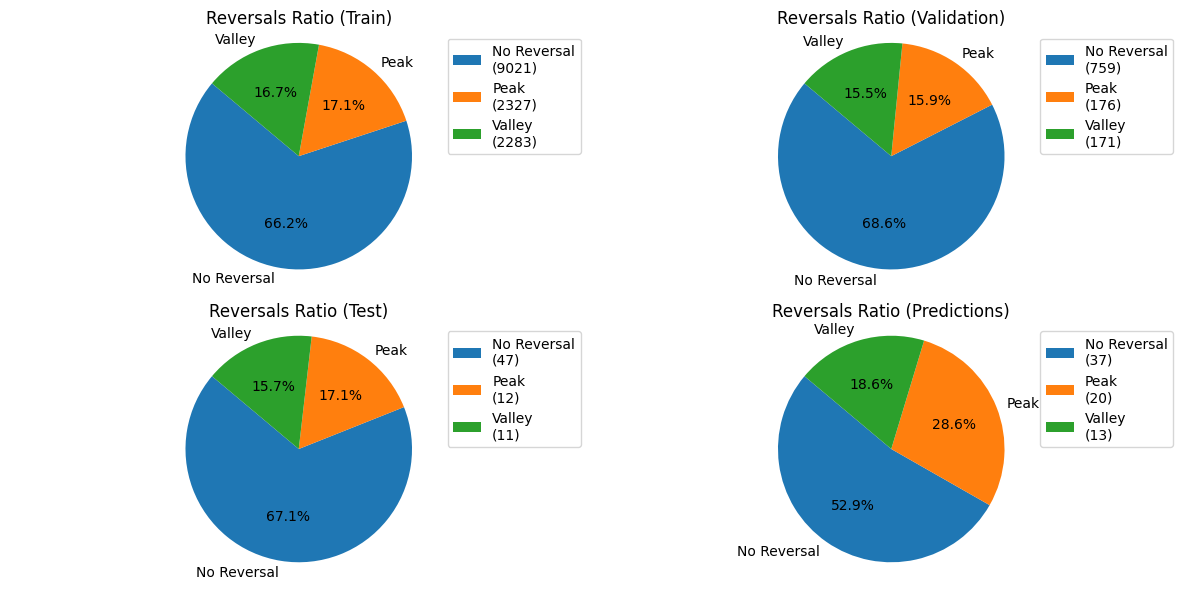

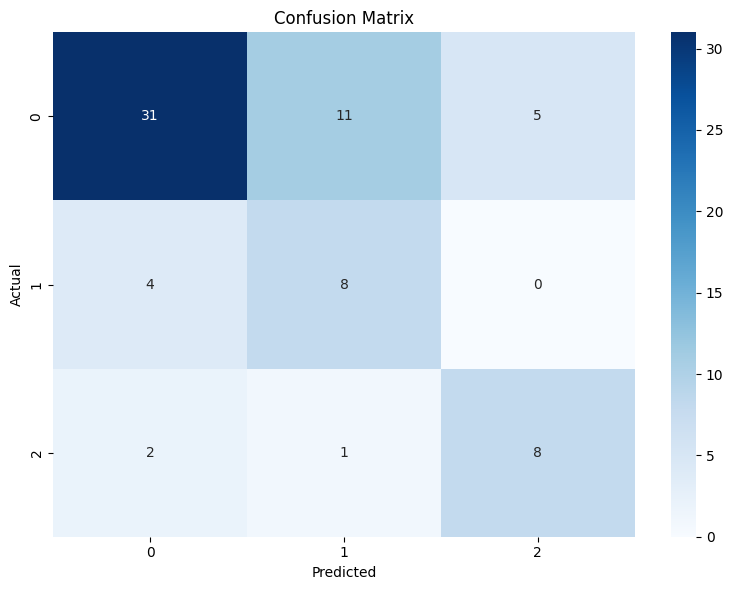

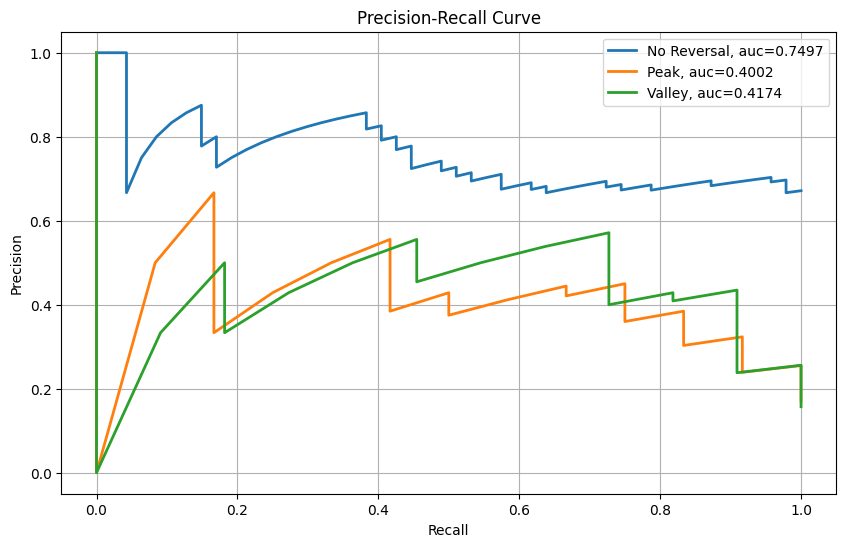

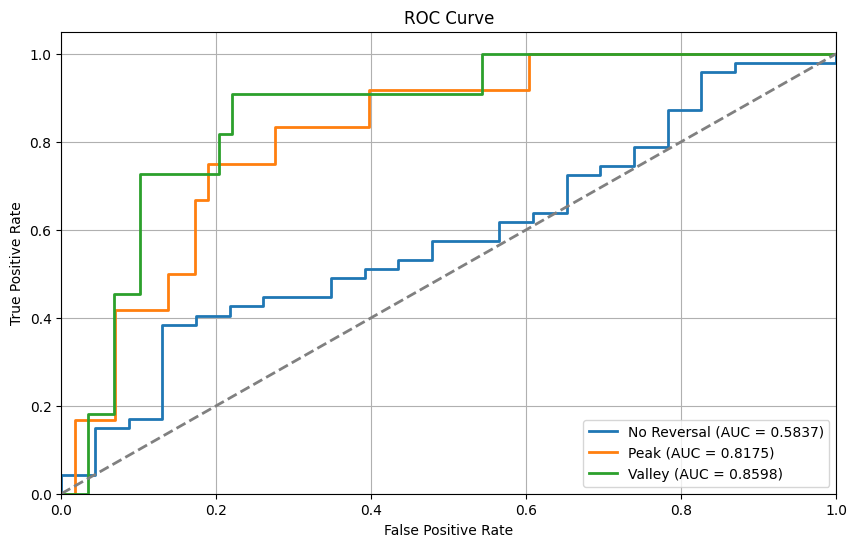

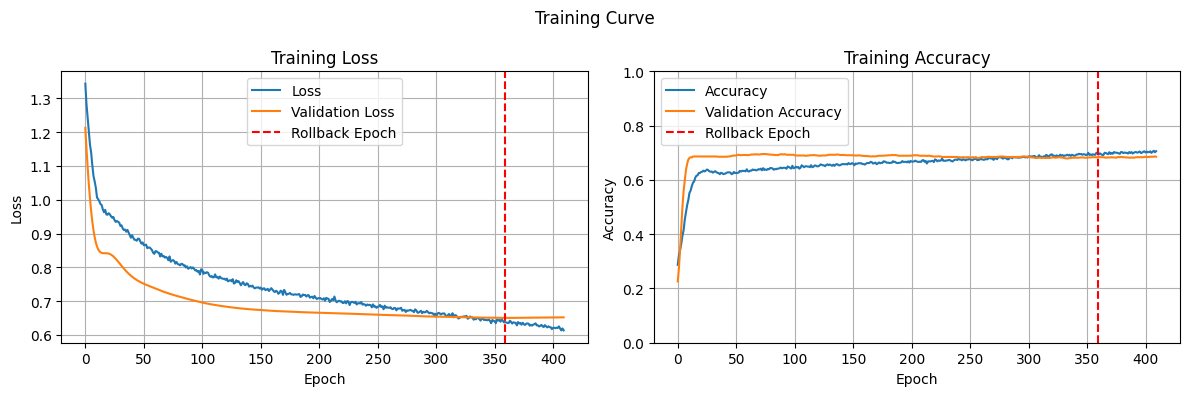

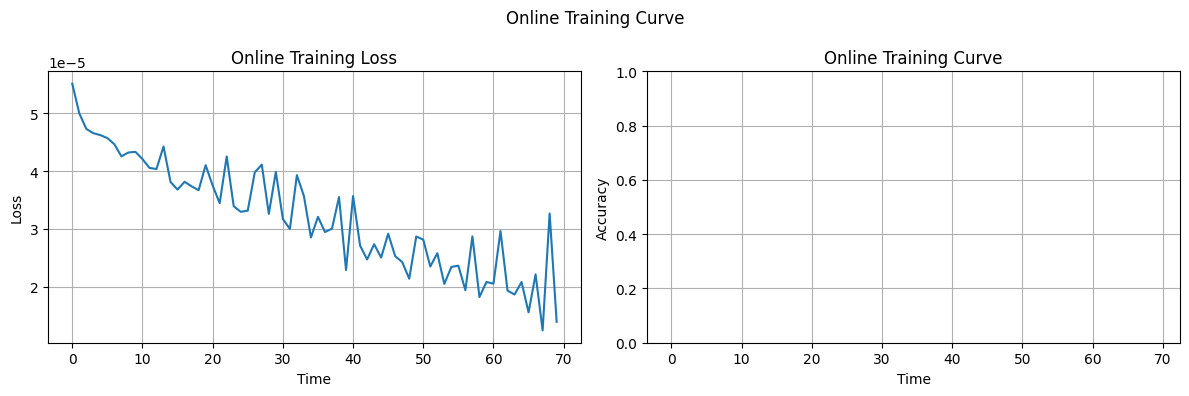

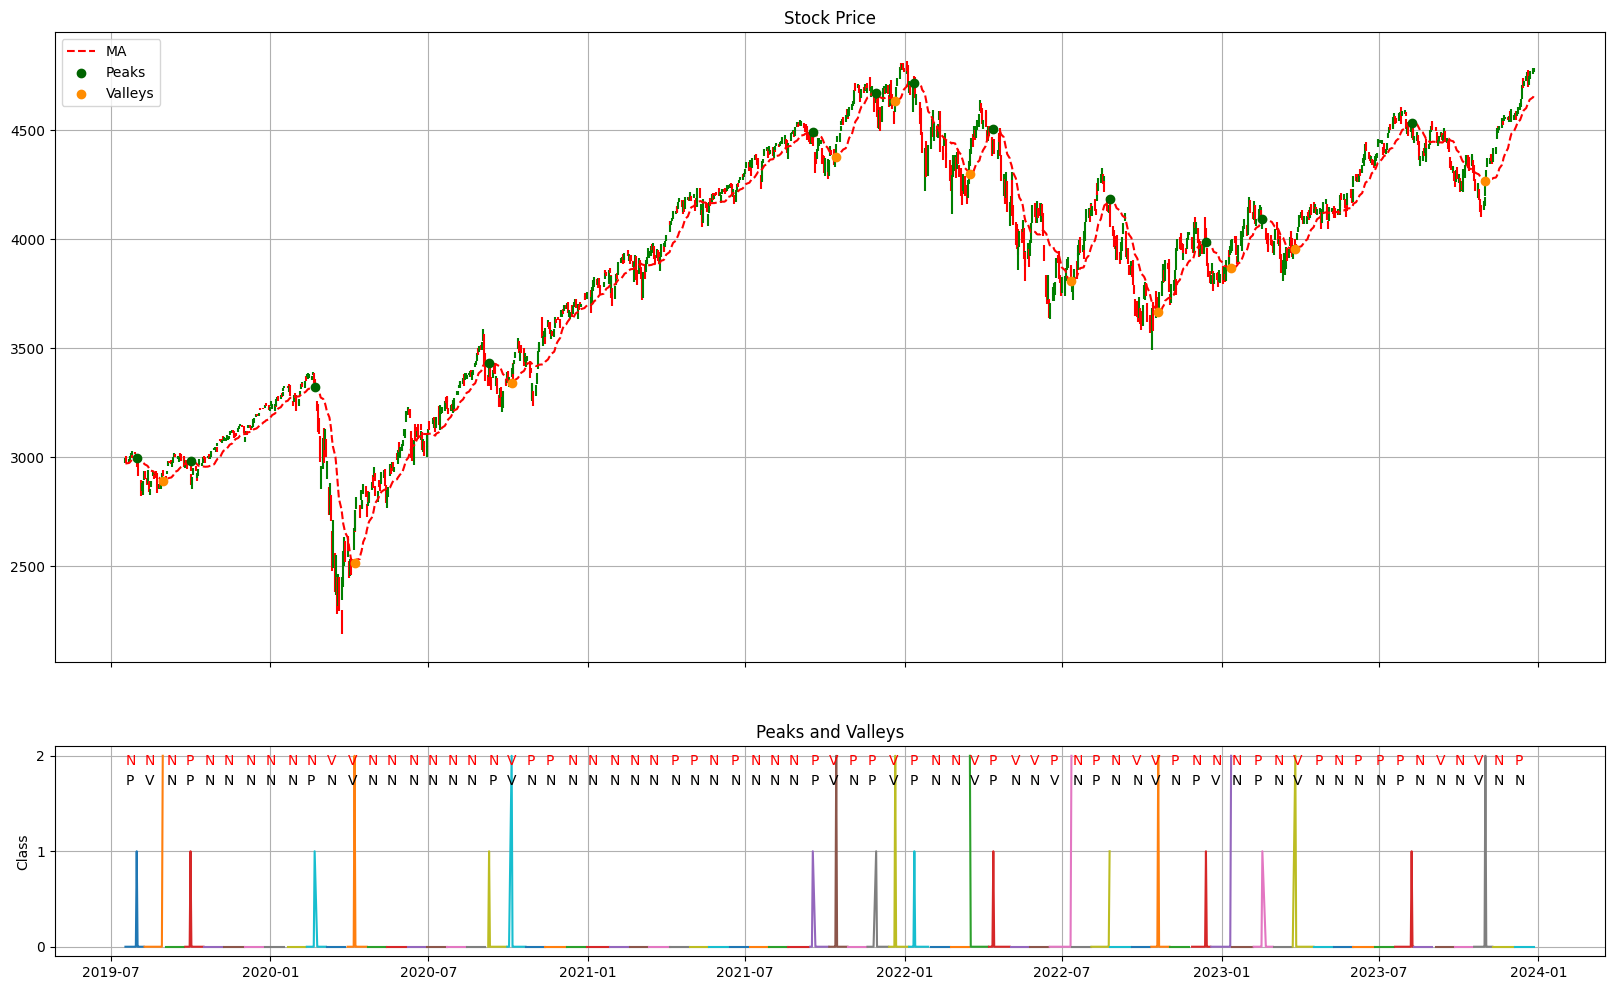

In [379]:
evaluator = Evaluator(params)

results = evaluator.get_results(y_test, y_preds)

In [380]:
y_train_max_indices = np.argmax(y_train, axis=-1)
y_val_max_indices = np.argmax(y_val, axis=-1)

In [381]:
y_train_label = evaluator._change_labels(y_train_max_indices, abbreviation=False)

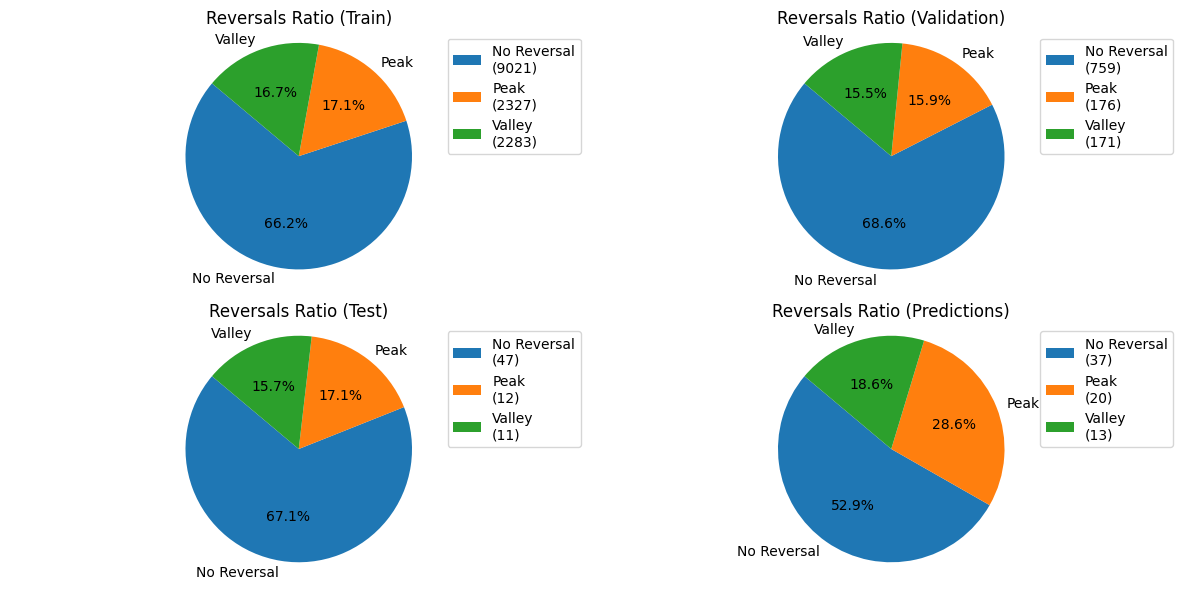

In [382]:
def plot_reversals_ratio_multi(y_train, y_val, y_test, y_preds):
    fig, axs = plt.subplots(2, 2, figsize=(12, 6))
    data_sets = [y_train, y_val, y_test, y_preds]
    set_labels = ['Train', 'Validation', 'Test', 'Predictions']
    
    for idx, y_data in enumerate(data_sets):
        y_data_label = evaluator._change_labels(y_data, abbreviation=False)
        counts = pd.DataFrame(y_data_label).value_counts()
        labels = ['No Reversal', 'Peak', 'Valley']
        
        row_idx = idx // 2
        col_idx = idx % 2
        
        ax_pie = axs[row_idx, col_idx]
        patches, texts, _ = ax_pie.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
        ax_pie.axis('equal')
        ax_pie.set_title(f'Reversals Ratio ({set_labels[idx]})')
        
        labels_text = [f'{label}\n({count})' for label, count in zip(labels, counts)]
        ax_pie.legend(patches, labels_text, loc='upper right')

    plt.tight_layout()
    plt.show()

plot_reversals_ratio_multi(y_train_max_indices, y_val_max_indices, y_test_max_indices, y_preds_max_indices)


In [383]:
results

{'confusion metrics': {'Class': {0: 0,
   1: 1,
   2: 2,
   3: 'Macro-average',
   4: 'Micro-average'},
  'Accuracy': {0: 0.6714285714285714,
   1: 0.6714285714285714,
   2: 0.6714285714285714,
   3: 0.6714285714285714,
   4: 0.6714285714285714},
  'Precision': {0: 0.8378378378378378,
   1: 0.4,
   2: 0.6153846153846154,
   3: 0.6177408177408178,
   4: 0.6714285714285714},
  'Recall': {0: 0.6595744680851063,
   1: 0.6666666666666666,
   2: 0.7272727272727273,
   3: 0.6845046206748334,
   4: 0.6714285714285714},
  'F1-Score': {0: 0.7380952380952381,
   1: 0.5,
   2: 0.6666666666666667,
   3: 0.634920634920635,
   4: 0.6714285714285714},
  'Specificity': {0: 0.7380952380952381,
   1: 0.7380952380952381,
   2: 0.7380952380952381,
   3: 0.7380952380952381,
   4: 0.7380952380952381},
  'False Positive Rate': {0: 0.2619047619047619,
   1: 0.2619047619047619,
   2: 0.2619047619047619,
   3: 0.2619047619047619,
   4: 0.2619047619047619},
  'False Negative Rate': {0: 0.6666666666666666,
   1: 0